## Stern Reproduce

Stern, Jonathan et al. 2023. ‘Accretion onto Disk Galaxies via Hot and Rotating CGM Inflows’. http://arxiv.org/abs/2306.00092 (August 30, 2023).

Mainly reproducing the analytical work, from figure 5.

In [106]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numba
from pathlib import Path

from matplotlib import rcParams
rcParams['font.size'] = 10
rcParams['figure.dpi'] = 300

rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif'

### A4 width = 8.268 x 11.693
### margins = 3cm --> 6cm = 2.362205 inch
MPL_STD_WIDTH = 5.905795
MPL_STD_RATIO = 6.4 / 4.8 # width / height (from default)
MPL_STD_HEIGHT = MPL_STD_WIDTH / MPL_STD_RATIO

rcParams['figure.figsize'] = (MPL_STD_WIDTH, MPL_STD_HEIGHT)

def save_name(fname, ext="pdf", path=None):
    if path is None:
        path = Path("./figures/stern2023")
    else:
        path = Path(path)

    return path / f"{fname}.{ext}"

def savefig(fig, name, ext="pdf", dpi=None, path=None, *args, **kwargs):
    if dpi is None:
        dpi = rcParams['figure.dpi']
    sname = save_name(name, ext=ext, path=path)
    fig.savefig(sname, dpi=dpi, bbox_inches = "tight")


In [9]:
from cycler import cycler
custom_cycler = cycler(color=['#fca50a', '#dd513a', '#993270', '#420a68', '#000000'])
plt.rc('axes', prop_cycle=custom_cycler)
plt.rc('axes', grid=False)

In [10]:
M_TO_PC = 3.240756e-17 # (pc / m)
A_YEAR = 60*60*24*365.25 # (s / Gyr)

### Parameters:

\begin{align*}
\Omega &\,[\text{rad}\, \text{Gyr}^{-1}]\\
T &\,[10^6 \text{K}]\\
n_H &\,[10^{-4} \text{cm}^{-3}]\\
 P/k &\,[10^6 \text{cm}^{-3}\text{K}]\\
\end{align*}

For $r = 45 \text{ kpc} \implies \epsilon = 0.1$ and $r = 25 \text{ kpc} \implies \epsilon = 0.4$

#### Non rotating solution:

\begin{align*}
\Omega &= 0\\
T &= 2.0 \times 10^6 v_{c, 200}^2 \text{K}\\
n_H &= 0.8\times 10^{-3}r_{10}^{-1.5} v_{c, 200}^2 \dot{M}_1^{0.5} \Lambda^{-0.5}_{-22}   \text{cm}^{-3}\\
 P/k &\,[10^6 \text{cm}^{-3}\text{K}]\\
\end{align*}

### Units:
$\newcommand{\cm}{\textrm{cm}}$
$\newcommand{\km}{\textrm{km}}$
$\newcommand{\sec}{\textrm{s}}$

From non rotating:
\begin{align*}
    T &: K\\
    n_H &: \cm^{-3}\\
    v_r &: \km / \sec\\
    P/k &: \cm^{-3} K\\
\end{align*}

From rotating:
\begin{align*}
    T_1 &: K\\
    n_{H,1} &: \cm^{-3}\\
    v_{r,1} &: \km / \sec\\
    v_{\theta,1} &: \km / \sec\\
    P_1/k &: \cm^{-3} K\\
\end{align*}

### Rotating

\begin{align*}
\Omega_1 &= \frac{v_c R_{circ}}{r^2}\\
P_1 &= P_0(r) \left(1 + \epsilon \left[ (3/4)\sin^2\theta - (5/8) \right] \right)\\
T_1 &= T_0 \left(1 - \epsilon \left[ 2\sin^2\theta - (5/6) \right] \right)\\
n_{H,1} &= (P_1 / k) (1 / T_1)\\
n_{H,1} &= n_{H,0} \left(1 + \epsilon \left[ (11/4)\sin^2\theta - (35/24) \right] \right)\\
\end{align*}

From Stern 2019: 

\begin{align*}
\Lambda_{-22} = 0.6\\
v_c = 140 r^m_{100} km /s, \text{ where } m = -0.1\\
\end{align*}

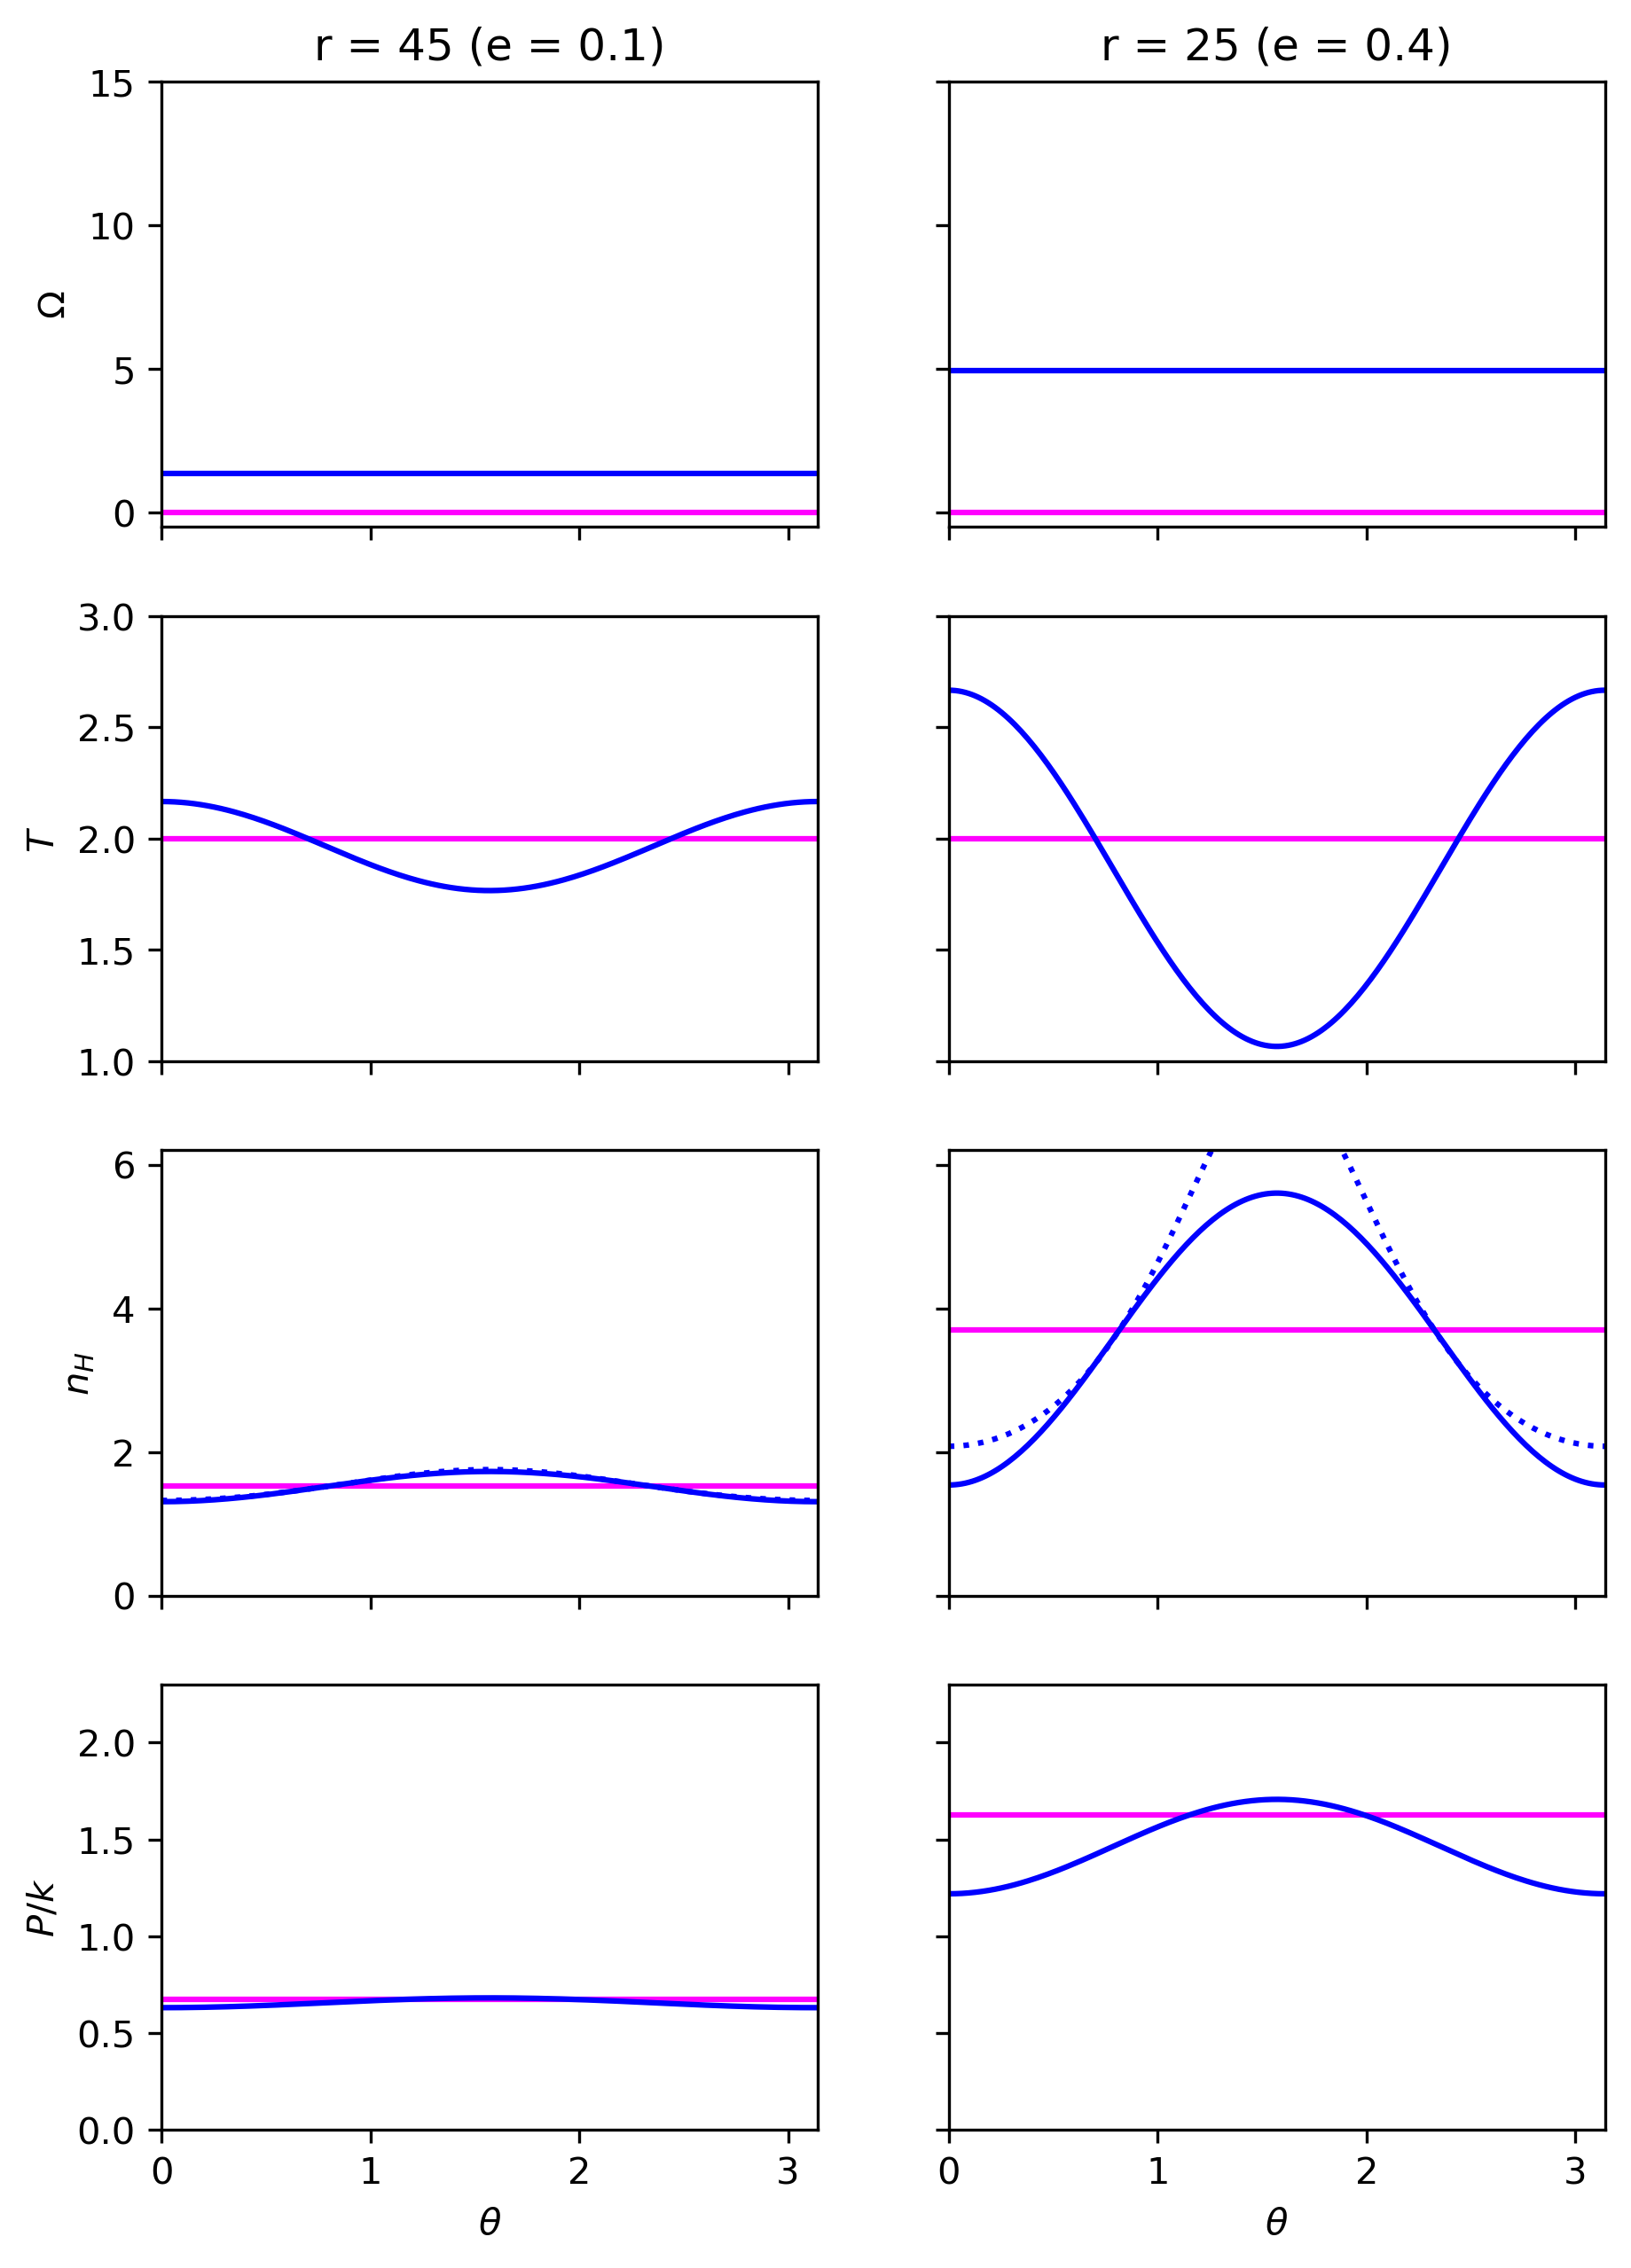

In [12]:
fig, axs = plt.subplots(4, 2, sharey='row', sharex='col', figsize=(7, 10))

# TODO: find out the parameters for velocity, cooling function and mass loss
theta = np.linspace(0, np.pi, 200)
for i, (r, e) in enumerate(zip([45, 25], [0.1, 0.4])):
    R_circ = np.sqrt(e) * r
    
#     m = -0.1
#     vc = 140*(r/100)**m # km / s, Stern 2019
#     vc_200 = vc / 200 # ?  => Value unclear
    vc_200 = 1.0 # ?  => Value unclear
    cooling_22 = 0.6 # Stern 2019
#     cooling_22 = 1 # ? => Value unclear
    Mdot = 2 # solar mass / year => Value unclear

    Omega_nr = 0
    T_nr = 2.0e6 * vc_200 **2  # K
    nH_nr = 0.8e-3 * (r / 10) **-1.5 * vc_200 * np.sqrt(Mdot / cooling_22)  # cm-3
    P_nr = T_nr*2.2*nH_nr # (is divided by boltzmann constant) Use: ideal gas law
    
    Omega_r = vc_200*200*R_circ / r**2 # km / s * kpc / kpc2 -> km / s / kpc
    Omega_r *= 1 / M_TO_PC / (A_YEAR*1e9) # remove km / kpc (= m / pc) and convert to 1 / Gyr
    P_r = P_nr*(1 + e*((3/4)*np.sin(theta)**2 - (5/8)))
    T_r = T_nr*(1 - e*(2*np.sin(theta)**2 - (5/6)))
    nH_r_old = P_r / T_r / 2.2
    nH_r  = nH_nr*(1 + e*((11/4)*np.sin(theta)**2 - (35/24)))

    axs[0, i].axhline(Omega_nr, c='magenta')
    axs[0, i].axhline(Omega_r, c='blue')
    axs[1, i].axhline(T_nr / 1e6, c='magenta')
    axs[1, i].plot(theta, T_r / 1e6, c='blue')
    axs[2, i].axhline(nH_nr / 1e-4, c='magenta')
    axs[2, i].plot(theta, nH_r / 1e-4, c='blue')
    axs[2, i].plot(theta, nH_r_old / 1e-4, c='blue', ls=':')
    axs[3, i].axhline(P_nr / 1e3, c='magenta')
    axs[3, i].plot(theta, P_r / 1e3, c='blue')
    
    axs[0, i].set_title(f'r = {r} (e = {e})')
    
axs[0, 0].set_ylim(-0.5, 15)
axs[1, 0].set_ylim(1, 3)
axs[2, 0].set_ylim(0, 6.2)
axs[3, 0].set_ylim(0, 2.3)

axs[0, 0].set_xlim(0, np.pi)
axs[0, 1].set_xlim(0, np.pi)

axs[0, 0].set_ylabel(r'$\Omega$')
axs[1, 0].set_ylabel(r'$T$')
axs[2, 0].set_ylabel(r'$n_H$')
axs[3, 0].set_ylabel(r'$P/k$')

axs[3, 0].set_xlabel(r'$\theta$')
axs[3, 1].set_xlabel(r'$\theta$')

plt.show()

Row 1 seems good, (maybe right, blue line slightly too high, should be 5?)

Row 2, $T_0$ should be slightly above 2 (so maybe $v_c$ needs to be slightly higher?)

Row 3, values seem too low? Either: $v_c\approx 200\,km/s, \dot{M} \approx 2$ too low, or $\Lambda \approx 10^{-22} \,erg/s$ too high.

Row 4, also too low. Likely due to $n_H$ being too low. Otherwise, use a total density $n$ and not just $n_H$?

From row 3, you can see that the assumption $nH = (P/k)/T$ is not great, so probably this is why $P_0$ is also off.

## Function for quantities

In [13]:
1 / M_TO_PC / (A_YEAR*1e9) # (m / pc) * (Gyr / s) --> almost 1

0.9777992485095747

In [14]:
vc_200 = 1.0 # ?  => Value unclear
cooling_22 = 0.6 # Stern 2019
#     cooling_22 = 1 # ? => Value unclear
Mdot = 2 # solar mass / year => Value unclear

Rcirc = 15 # kpc (from the simulations, maybe slightly off?)

@numba.jit(nopython=True)
def quantities(r,theta):
    """
    r: in kpc
    theta: 0-pi
    """
    e = (Rcirc / r)**2
    factor = 2.2
    t_cool = 370*(r / 10)**1.5* vc_200 * np.sqrt(1 / Mdot / cooling_22) # Myr
    
    T0 = 2.0e6 * vc_200 **2
    nH0 = 0.8e-3 * (r / 10) **-1.5 * vc_200 * np.sqrt(Mdot / cooling_22)
    P0 = T0*factor*nH0 # (is divided by boltzmann constant) Use: ideal gas law
    
    #vr0 = -r / t_cool # is in kpc / Myr, so instead we use below:
    vr0 = -27*np.sqrt(1/(r/10) * Mdot * cooling_22) / vc_200 # km / s

    Omega_r = vc_200*200*R_circ / r**2 # units: (km / s) / kpc
    Omega_r *= 1 / M_TO_PC / (A_YEAR*1e9) # factor km / kpc (= m / pc) and convert to 1 / Gyr
    
    P1 = P0*(1 + e*((3/4)*np.sin(theta)**2 - (5/8)))
    T1 = T0*(1 - e*(2*np.sin(theta)**2 - (5/6)))
    nH1 = nH0*(1 + e*((11/4)*np.sin(theta)**2 - (35/24)))
    vr1 = vr0*(1 - e*((23/12)*np.sin(theta)**2 - (65/72)))
    vth = -vr0*(5/18)*e*np.sin(2*theta)
    
    return (T0, nH0, P0, vr0), (Omega_r, P1, T1, nH1, vr1, vth), e

quantities(45, 1.5)

((2000000.0, 0.00015300674947979918, 673.2296977111164, -13.9427400463467),
 (1.5269494912055592,
  682.2993873256379,
  1742964.6303850862,
  0.00017473211577706692,
  -12.386887709752845,
  0.0607283823369469),
 0.1111111111111111)

In [15]:
def compute_phi(path):
    t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e = path.T
    dt = t[1] - t[0] # s
    phi = 0 # rad
    phis = [phi]
    
    # Is initially per Gyr
    Omega_per_s = Omega_r / (A_YEAR * 1e9)
    for om in Omega_per_s[:-1]:
        phi = phi + dt*om
        phis.append(phi)
        
    return phis

### CHECK: (if the plots still make sense)

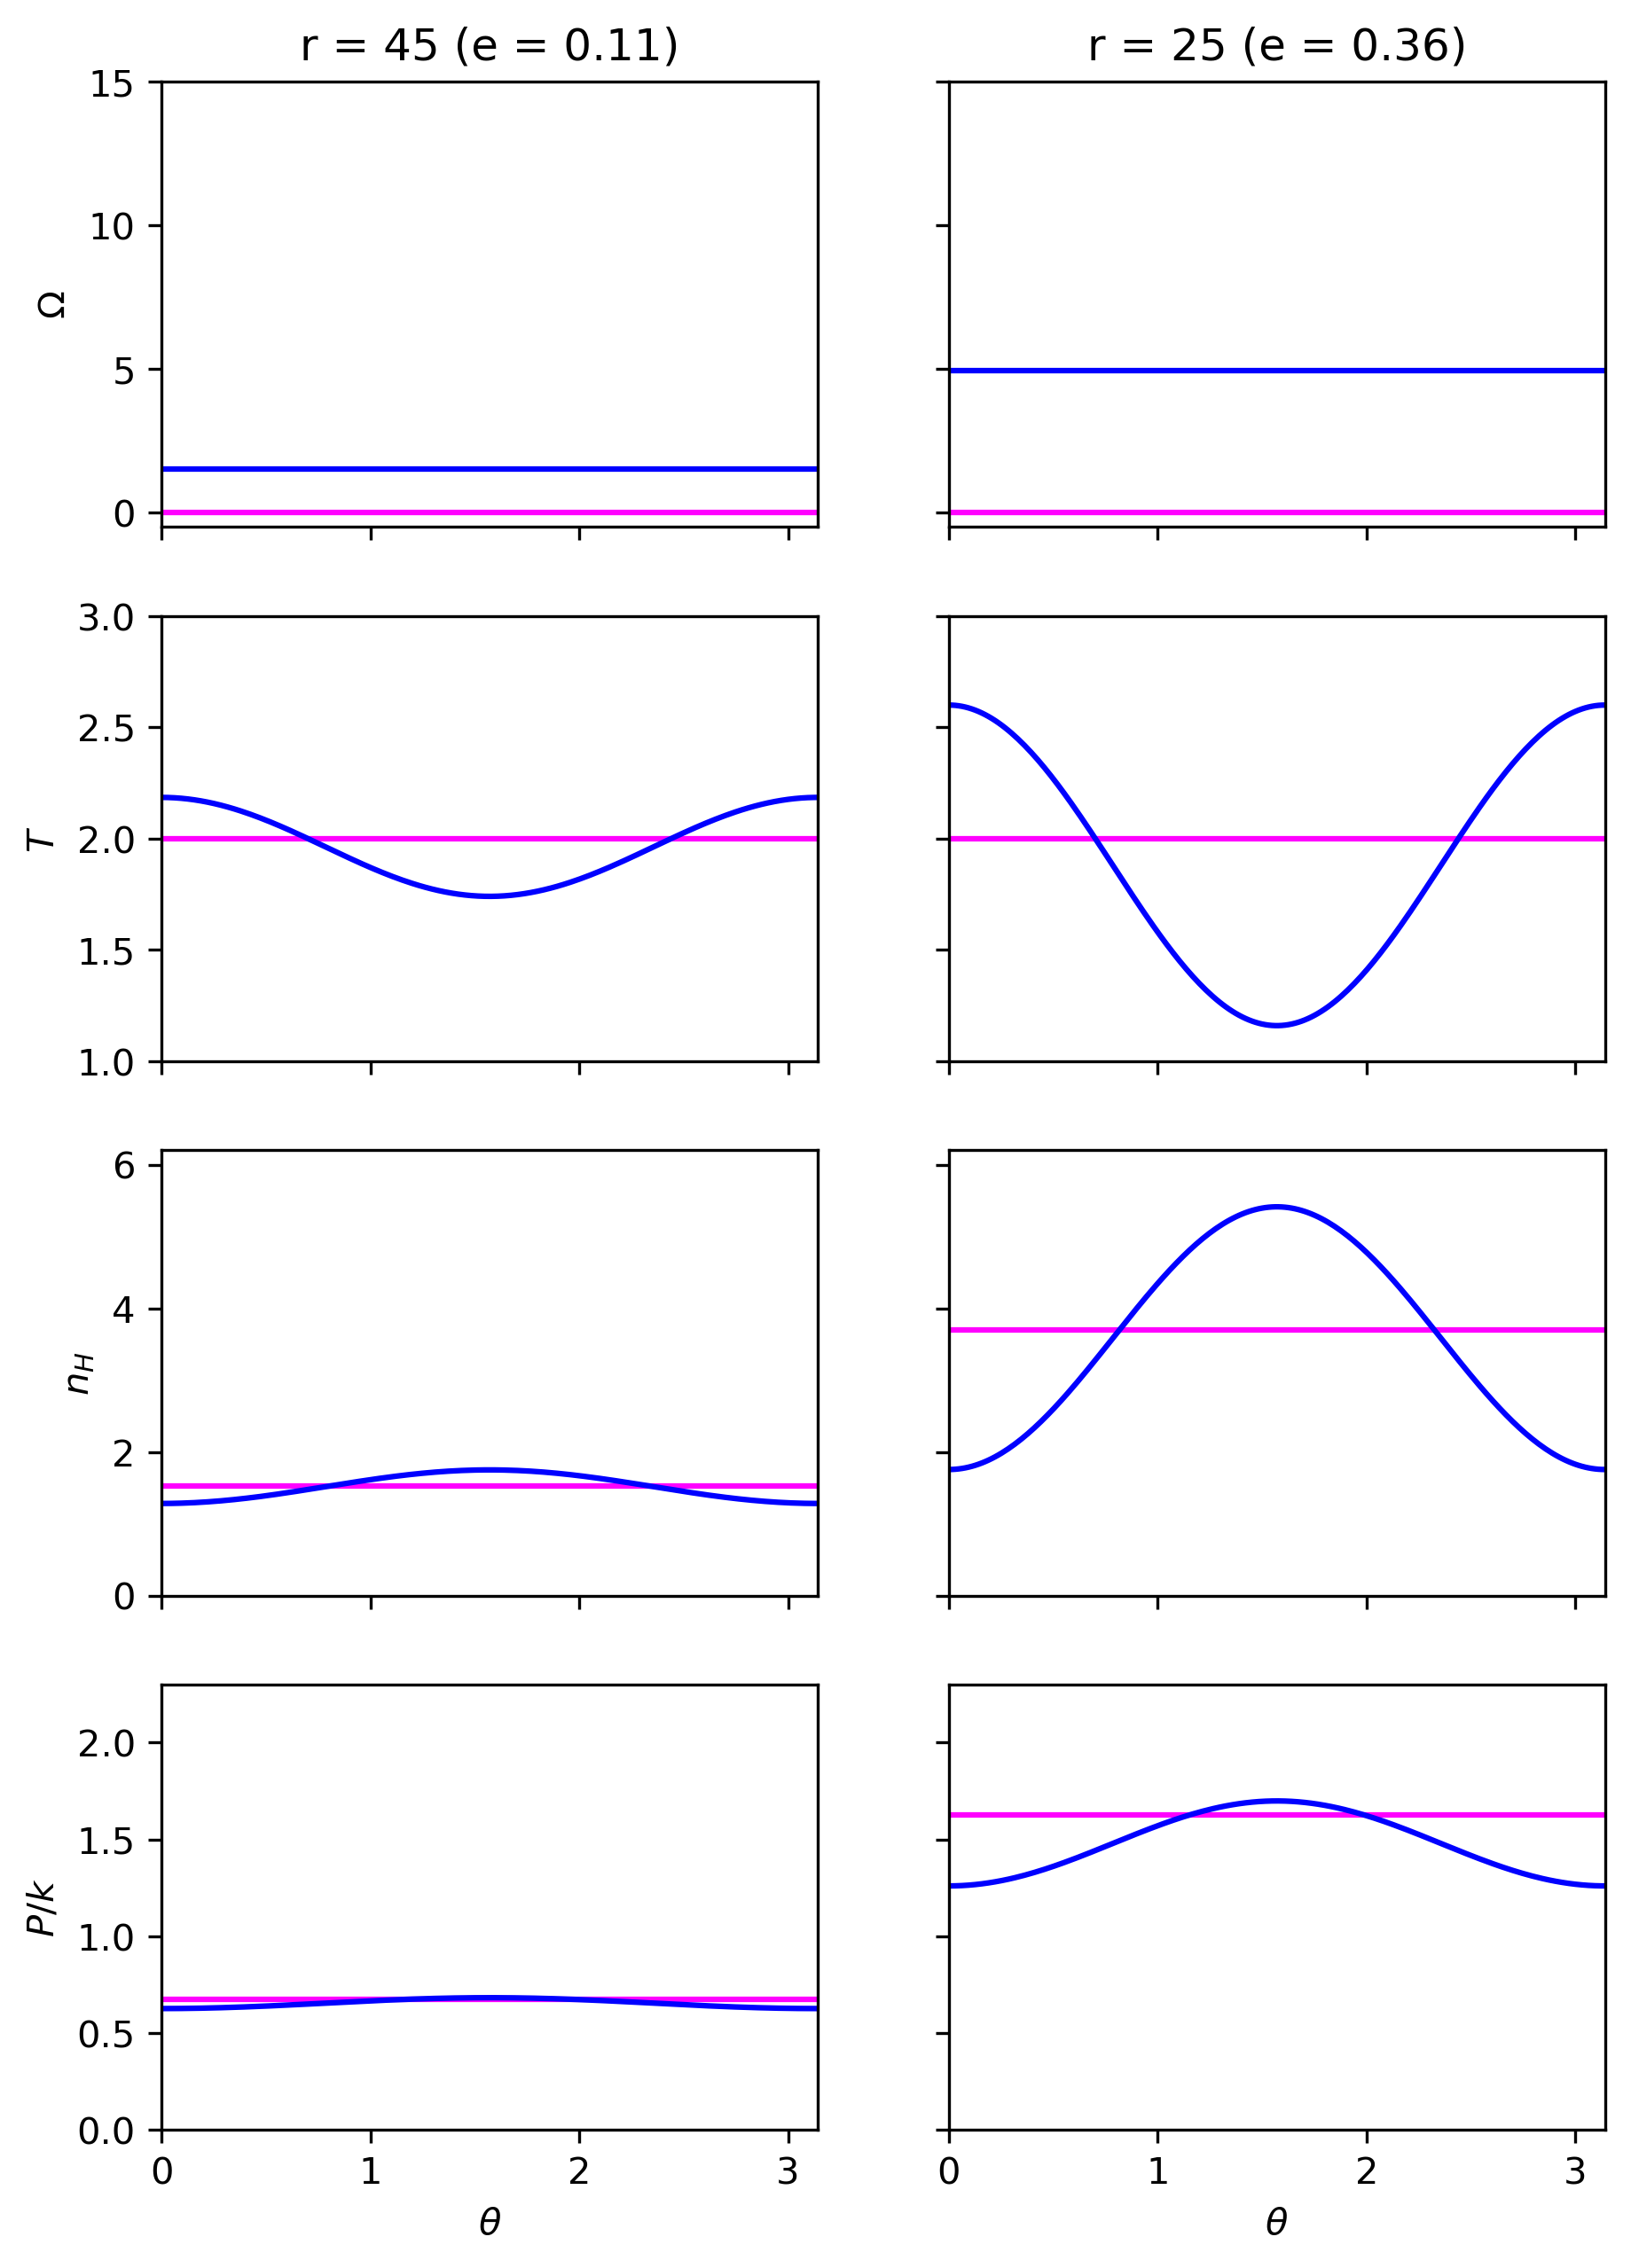

In [16]:
fig, axs = plt.subplots(4, 2, sharey='row', sharex='col', figsize=(7, 10))

# TODO: find out the parameters for velocity, cooling function and mass loss
theta = np.linspace(0, np.pi, 200)
for i, r in enumerate([45, 25]):
    
    (T_nr, nH_nr, P_nr, vr_nr), (Omega_r, P_r, T_r, nH_r, vr_r, vrth), e = quantities(r, theta)

    axs[0, i].axhline(0, c='magenta')
    axs[0, i].axhline(Omega_r, c='blue')
    axs[1, i].axhline(T_nr / 1e6, c='magenta')
    axs[1, i].plot(theta, T_r / 1e6, c='blue')
    axs[2, i].axhline(nH_nr / 1e-4, c='magenta')
    axs[2, i].plot(theta, nH_r / 1e-4, c='blue')
    axs[3, i].axhline(P_nr / 1e3, c='magenta')
    axs[3, i].plot(theta, P_r / 1e3, c='blue')
    
    axs[0, i].set_title(f'r = {r} (e = {e:.2f})')
    
axs[0, 0].set_ylim(-0.5, 15)
axs[1, 0].set_ylim(1, 3)
axs[2, 0].set_ylim(0, 6.2)
axs[3, 0].set_ylim(0, 2.3)

axs[0, 0].set_ylabel(r'$\Omega$')
axs[1, 0].set_ylabel(r'$T$')
axs[2, 0].set_ylabel(r'$n_H$')
axs[3, 0].set_ylabel(r'$P/k$')

axs[3, 0].set_xlabel(r'$\theta$')
axs[3, 1].set_xlabel(r'$\theta$')
axs[3, 0].set_xlim(0, np.pi)
axs[3, 1].set_xlim(0, np.pi)

plt.show()

Figure 5: 
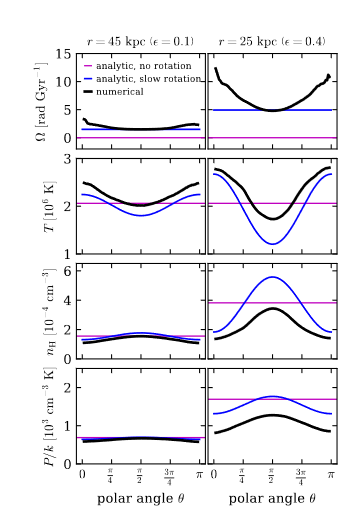

## Path integrator
$\newcommand{\vp}{\textbf{p}}$
$\newcommand{\vv}{\textbf{v}}$

At each position $\textbf{p}(t) = (r(t), \theta(t))$, we can calculate velocity $\textbf{v}(t) \implies \vv(\vp(t)) = (v_r(\vp), v_\theta(\vp))$ and update the position, given some timestep $dt$:
$$\textbf{p}(t+dt) = \vp(t) + \vv(\vp(t))dt$$

Note that to actually update $\theta$ (units of radians), we need to add the term $1 / r$ to convert from kpc to radians:

\begin{align*}
    r(t+dt) &:= r(t) + v_r(t)dt\\
    \theta(t+dt) &:= \theta(t) + \frac{v_\theta(t)}{r}dt\\
\end{align*}

In [17]:
#         (T0, nH0, P0, vr0), (Omega_r, P1, T1, nH1, vr1, vth), e = res
#          3   4    5   6      7        8   9   10   11   12     13

@numba.jit(nopython=True)
def particle_path_nr(r0, theta0, r_lim=1e-10, dt=1e-5, max_iter=10000000):
    dt = A_YEAR*1e9*dt
    t = 0 # Unit: s
    r = r0 # kpc
    theta = theta0 # rad
    phi = 0 # Unit: rad
    result = []
    for i in range(max_iter):
        # Calculate
        res = quantities(r, theta)
        
        (T0, nH0, P0, vr0), (Omega_r, P1, T1, nH1, vr1, vth), e = res
        # Store
        result.append([t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e])
        
        # Update using the non-rotating solution (theta remains constant)
        dr = M_TO_PC * vr0*dt
        r = r + dr
        t = t + dt
        
        if r < 0:
            print("Negative r, so we reached 0.")
            break

        if abs(dr) < r_lim:
            print("dr < r_lim (limit reached), stopping early...")
            break

    result = np.asarray(result)
    return result, i
    

@numba.jit(nopython=True)
def particle_path(r0, theta0, r_lim=1e-10, dt=1e-5, max_iter=10000000):
    # dt is in Gyr
    # r_lim: lower limit of change in [kpc] per dt
    dt = A_YEAR*1e9*dt
    t = 0 # Unit: s
    r = r0 # kpc
    
    theta = theta0 # rad
    result = []
    for i in range(max_iter):
        # Calculate
        res = quantities(r, theta)
        
        (T0, nH0, P0, vr0), (Omega_r, P1, T1, nH1, vr1, vth), e = res
        # Store
        result.append([t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e])
        
        # Update using the rotating solution
        dr = M_TO_PC * vr1*dt
        dtheta = M_TO_PC * vth*dt/r
        r = r + dr
        theta = theta + dtheta
        t = t + dt

        if abs(dr) < r_lim:
            print(f"dr < r_lim (limit reached), stopping early...")
            break

    result = np.asarray(result)
    return result, i

## Plotting funcs:
### General Plot


In [18]:
def plot_path(path, figax=None):
    t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e = path.T
    
    if figax is None:
        figax = plt.subplots(4, 3, figsize=(12, 12), sharex=True, tight_layout=True)
    fig, axs = figax

    R = r*np.sin(theta)
    z = r*np.cos(theta)

    def find_temp(T, target):
        lower = np.arange(len(T))[T<target]
        if len(lower) == 0:
            return len(T)-1
        return lower[0]

    t_Tat5 = t[find_temp(T1, 1e5)]
    t_rel = (t - t_Tat5) / (A_YEAR * 1e9) # Gyr

    axs[0, 0].plot(t_rel, Omega_r)
    axs[0, 0].set_ylabel("Omega [rad / Gyr]")

    jz = R**2*Omega_r # kpc**2 / Gyr
    axs[1, 0].plot(t_rel, jz)
    axs[1, 0].set_ylabel("j_z [kpc^2 / Gyr]")

    axs[2, 0].plot(t_rel, -vr1)
    axs[2, 0].set_ylabel("-v_r")

    axs[3, 0].plot(t_rel, vth)
    axs[3, 0].set_ylabel("v_th")

    axs[0, 1].plot(t_rel, e)
    axs[0, 1].set_ylabel("e")


    axs[1,1].plot(t_rel, P1/1e3)
    axs[1,1].set_ylabel("P/k")

    axs[2,1].plot(t_rel, nH1/1e-3)
    axs[2,1].set_ylabel("nH")

    axs[3,1].plot(t_rel, T1)
    axs[3,1].set_yscale("log")
    axs[3,1].set_ylabel("T")


    axs[0, 2].plot(t_rel, r, label='r')
    axs[0, 2].set_ylabel("r [kpc]")
    axs[0, 2].axhline(Rcirc, ls=':', label='R_circ')

    axs[1, 2].plot(t_rel, R, label='R')
    axs[1, 2].set_ylabel("R [kpc]")
    axs[1, 2].axhline(Rcirc, ls=':', label='R_circ')

    axs[2, 2].plot(t_rel, z, label='z')
    axs[2, 2].set_ylabel("z [kpc]")

    axs[3, 2].plot(t_rel, theta)
    axs[3, 2].set_ylabel("theta")


    for ax in axs.flatten():
        ax.axvline(0, ls='--', c='gray')

    axs[3, 2].set_xlabel('t [Gyr]')
    axs[3, 1].set_xlabel('t [Gyr]')
    axs[3, 0].set_xlabel('t [Gyr]')

    return figax

dr < r_lim (limit reached), stopping early...


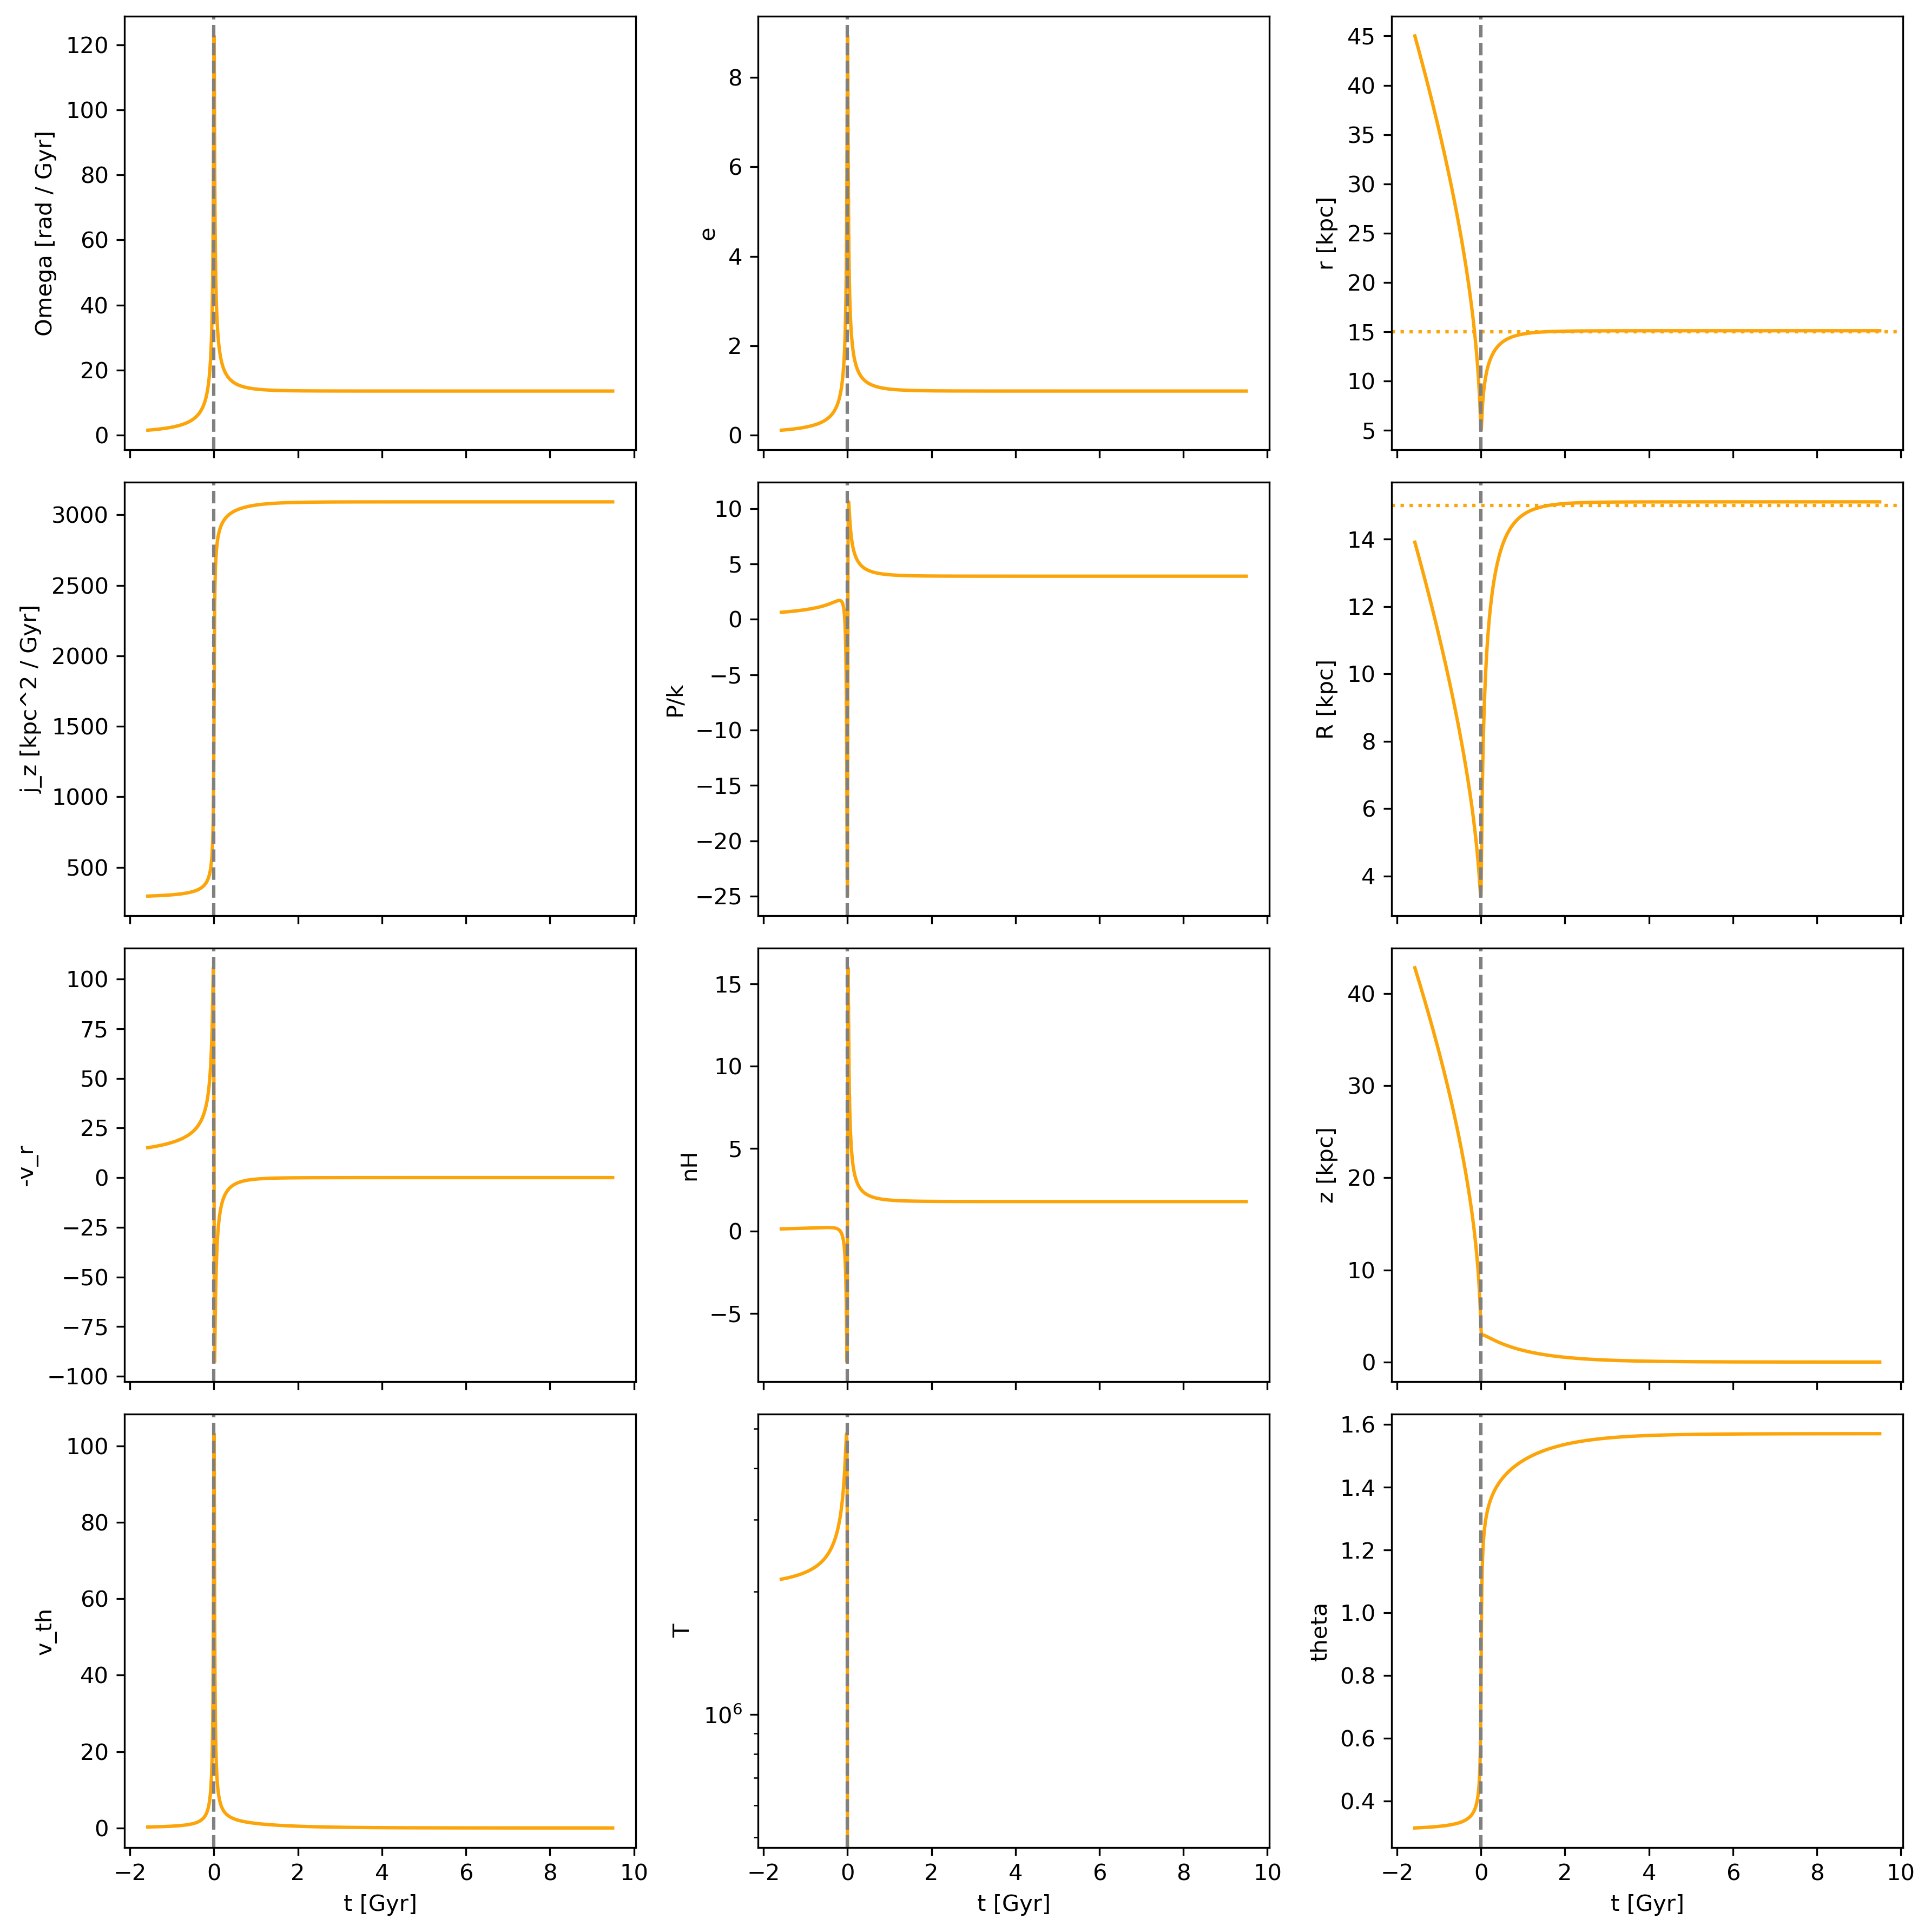

In [19]:
path,i = particle_path(45, 0.1*np.pi, dt=1e-3)#, max_iter=1000)
figax = plot_path(path)

### Figure 3

In [20]:
def plot_fig3(path, figax=None, Rcirc=15, **kwargs):
    t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e = path.T
    
    if figax is None:
        figax = plt.subplots(4, 1, figsize=(5, 12), sharex=True, tight_layout=True)
    fig, axs = figax

    R = r*np.sin(theta)
    z = r*np.cos(theta)
    v_phi = R*Omega_r
    
    t_plot = t / (A_YEAR*1e9) # s to Gyr
    
    axs[0].plot(t_plot, r, **kwargs)
    axs[0].set_ylabel('r [kpc]')
    line_rcirc = axs[0].axhline(Rcirc, ls=':', label=r'$R_{\rm circ}$ = ' + f'{Rcirc}')
    
    axs[1].plot(t_plot, theta, **kwargs)
    axs[1].set_ylabel(r'$\theta$')
    
    axs[2].plot(t_plot, T1 / 1e6, **kwargs)
    axs[2].set_ylabel(r'T [$10^6$K]')
    axs[2].set_ylim(0, 5)
    
    axs[3].plot(t_plot, v_phi, **kwargs)
    axs[3].set_ylabel(r'$v_{\phi}$ [km/s]') # CHECK UNIT
    
    axs[1].legend(loc='right')
    axs[0].legend([line_rcirc], [r"$R_{circ} = 15$kpc"], loc='upper right')
    axs[3].set_xlabel('time since $r = 40$kpc [Gyr]')
    
    return figax

dr < r_lim (limit reached), stopping early...


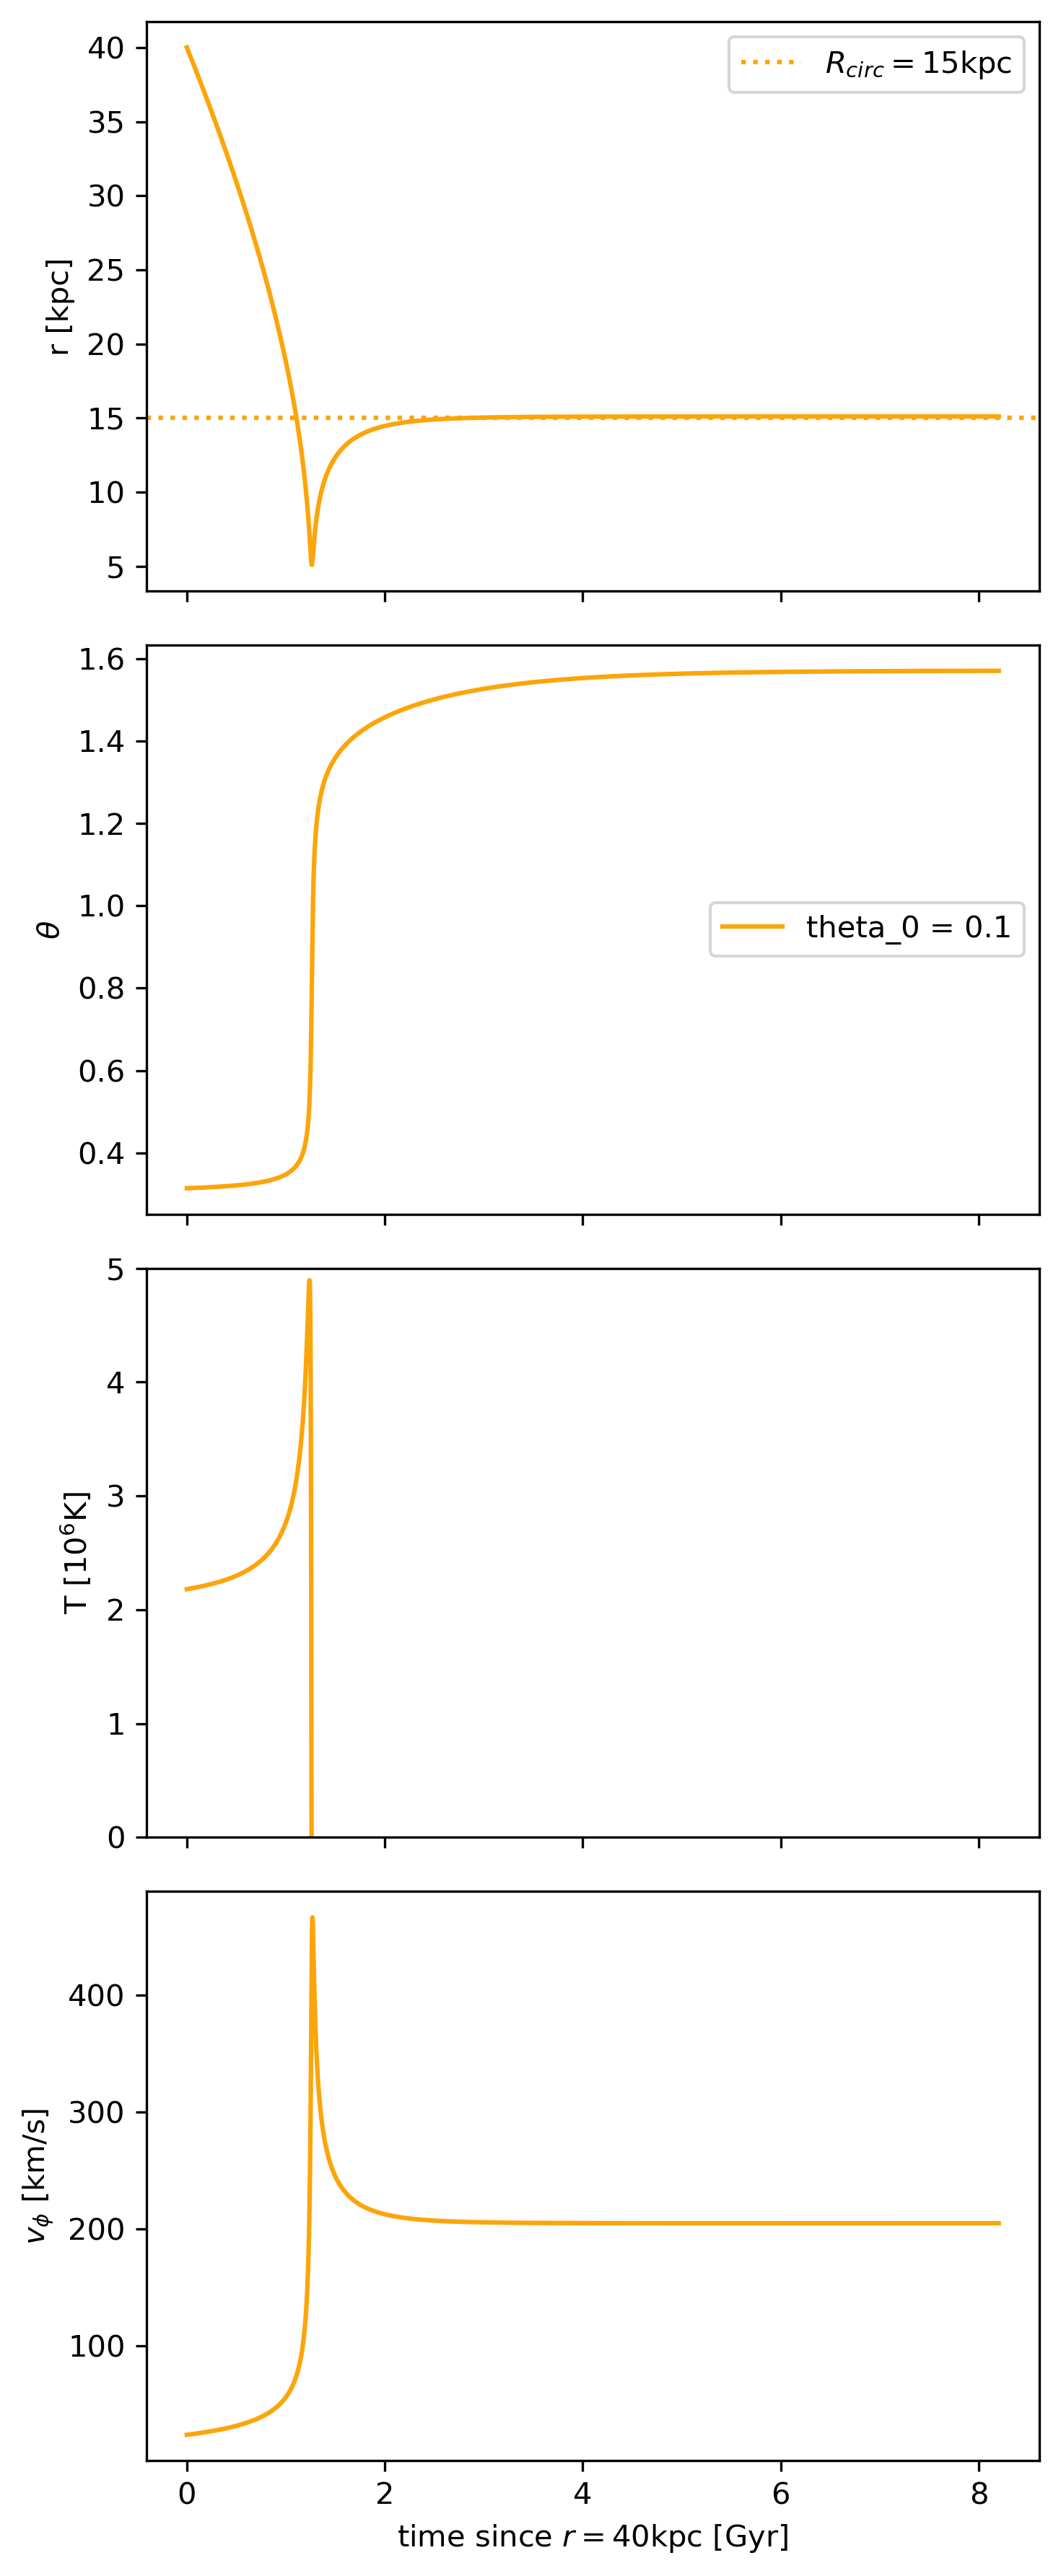

In [21]:
path,i = particle_path(40, 0.1*np.pi)
figax = plot_fig3(path, label='theta_0 = 0.1')

### Figure 5

In [22]:
def plot_fig5(path, figax=None, Rcirc=15, **kwargs):
    t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e = path.T
    
    if figax is None:
        figax = plt.subplots(3, 3, figsize=(12, 12), sharex=True, tight_layout=True)
    fig, axs = figax
    
    phi = compute_phi(path)


    R = r*np.sin(theta)
    z = r*np.cos(theta)
    v_phi = R*Omega_r # kpc / Gyr
    v_phi *= 1 / (A_YEAR*1e9) / M_TO_PC # km / s
    
    jz = R*v_phi # kpc* (km / s)
    
    def find_temp(T, target):
        lower = np.arange(len(T))[T>target]
        if len(lower) == 0:
            return len(T)-1
        return lower[-1]

    t_Tat5 = t[find_temp(T1, 1e5)]
#     t_Tat5 = t[find_temp(e, 0.5)]
    t_rel = (t - t_Tat5) / (A_YEAR * 1e9) # Gyr
    
    
    axs[0, 0].plot(t_rel, R, **kwargs)
    axs[0, 0].set_ylabel(r'$R_{\rm cycl}$ [kpc]')
    line_rcirc = axs[0, 0].axhline(Rcirc, ls=':', label=r'$R_{\rm circ}$ = ' + f'{Rcirc}')
    
    axs[1, 0].plot(t_rel, T1, **kwargs)
    axs[1, 0].set_ylabel(r'T [K]')
    axs[1, 0].set_yscale('log')
    
    axs[0, 2].plot(t_rel, e, **kwargs)
    axs[0, 2].set_ylabel(r'e')
    
    axs[0, 1].plot(t_rel, z, **kwargs)
    axs[0, 1].set_ylabel(r'z [kpc]')
    
    axs[1, 1].plot(t_rel, nH1, **kwargs)
    axs[1, 1].set_ylabel(r'$n_H$ [$cm^{-3}$]')
    axs[1, 1].set_yscale('log')
    axs[1, 1].set_ylim(1e-4, 6)
    
    
    axs[1, 2].plot(t_rel, P1, **kwargs)
    axs[1, 2].set_ylabel(r'$P/k$ [$cm^{-3} \, K$ ]')
    axs[1, 2].set_yscale('log')
    axs[1, 2].set_ylim(100, 2e5)
    
    axs[2, 2].plot(t_rel, jz / 1e3, **kwargs)
    axs[2, 2].set_ylabel(r'$j_z \,\, [10^3$ kpc km / s$]$')
    
    axs[2,0].plot(t_rel, phi, **kwargs)
    axs[2, 0].set_ylabel(r'$\phi - \phi_0$ [rad]')
    
    axs[1,1].legend(loc='upper left')
    axs[0,0].legend([line_rcirc], [r"$R_{circ} = 15$kpc"], loc='upper right')
    for ax in axs[2,:]:
        ax.set_xlabel(r'time since $10^5$K [Gyr]')
    
    for ax in axs.flatten():
        ax.axvline(0, ls='--', color='gray')
    
    return figax

dr < r_lim (limit reached), stopping early...


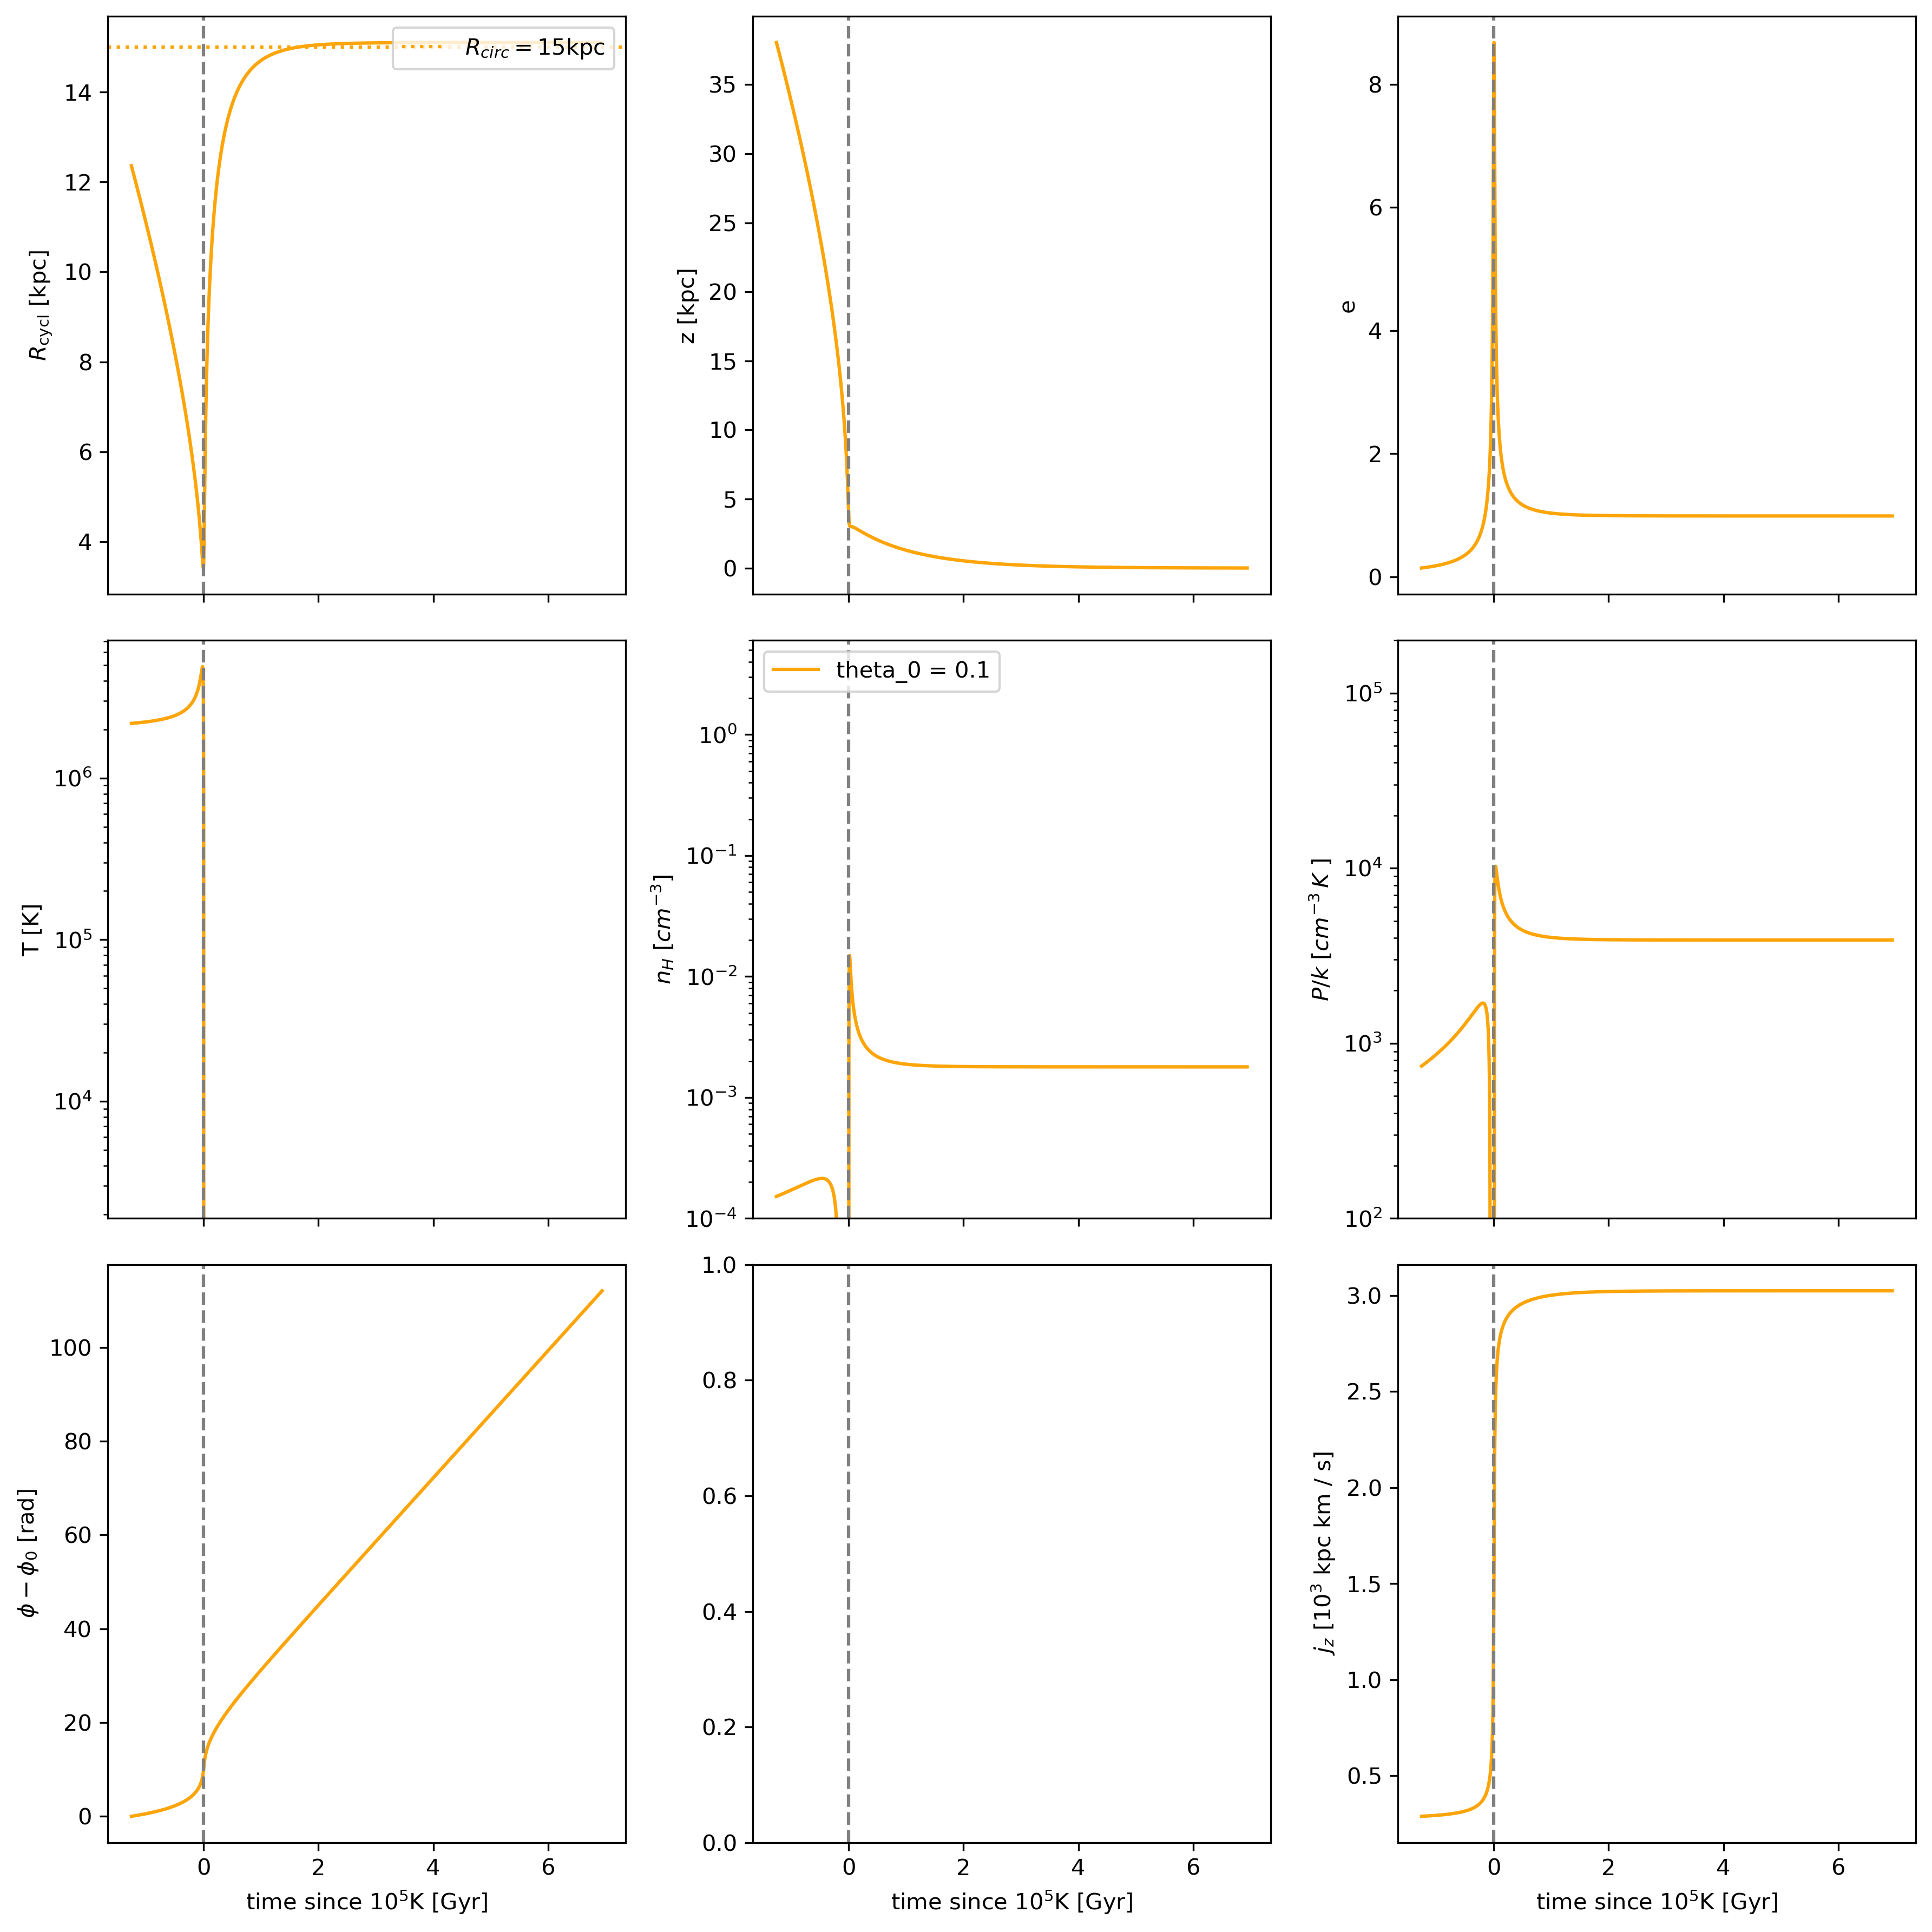

In [23]:
path,i = particle_path(40, 0.1*np.pi)
figax = plot_fig5(path, label='theta_0 = 0.1')

In [24]:
def plot_fig5_e(path, figax=None, Rcirc=15, **kwargs):
    t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e = path.T
    
    if figax is None:
        figax = plt.subplots(3, 3, figsize=(12, 12), sharex=True, tight_layout=True)
    fig, axs = figax
    
    phi = compute_phi(path)

    R = r*np.sin(theta)
    z = r*np.cos(theta)
    v_phi = R*Omega_r # kpc / Gyr
    v_phi *= 1 / (A_YEAR*1e9) / M_TO_PC # km / s
    
    jz = R*v_phi # kpc* (km / s)
    
    def find_temp(T, target):
        lower = np.arange(len(T))[T<target]
        if len(lower) == 0:
            return len(T)-1
        return lower[-1]

    t_Tat5 = t[find_temp(e, 0.5)]
    t_rel = (t - t_Tat5) / (A_YEAR * 1e9) # Gyr
    
    
    axs[0, 0].plot(t_rel, R, **kwargs)
    axs[0, 0].set_ylabel(r'$R_{\rm cycl}$ [kpc]')
    line_rcirc = axs[0, 0].axhline(Rcirc, ls=':', label=r'$R_{\rm circ}$ = ' + f'{Rcirc}')
    
    axs[1, 0].plot(t_rel, T1, **kwargs)
    axs[1, 0].set_ylabel(r'T [K]')
    axs[1, 0].set_yscale('log')
    
    
    
    axs[0, 2].plot(t_rel, e, **kwargs)
    axs[0, 2].set_ylabel(r'e')
#     axs[0, 2].set_yscale('log')
    
    axs[0, 1].plot(t_rel, z, **kwargs)
    axs[0, 1].set_ylabel(r'z [kpc]')
    
    axs[1, 1].plot(t_rel, nH1, **kwargs)
    axs[1, 1].set_ylabel(r'$n_H$ [$cm^{-3}$]')
    axs[1, 1].set_yscale('log')
    axs[1, 1].set_ylim(1e-4, 6)
    
    
    axs[1, 2].plot(t_rel, P1, **kwargs)
    axs[1, 2].set_ylabel(r'$P/k$ [$cm^{-3} \, K$ ]')
    axs[1, 2].set_yscale('log')
    axs[1, 2].set_ylim(100, 2e5)
    
    axs[2, 2].plot(t_rel, jz / 1e3, **kwargs)
    axs[2, 2].set_ylabel(r'$j_z \,\, [10^3$ kpc km / s$]$')
    
    
    axs[2,0].plot(t_rel, phi, **kwargs)
    axs[2, 0].set_ylabel(r'$\phi - \phi_0$ [rad]')
    
    axs[1,1].legend(loc='upper left')
    axs[0,0].legend([line_rcirc], [r"$R_{circ} = 15$kpc"], loc='upper right')
    for ax in axs[2,:]:
        ax.set_xlabel('time since $\epsilon = 0.5$ [Gyr]')
    
    for ax in axs.flatten():
        ax.axvline(0, ls='--', color='gray')
    
    return figax

dr < r_lim (limit reached), stopping early...


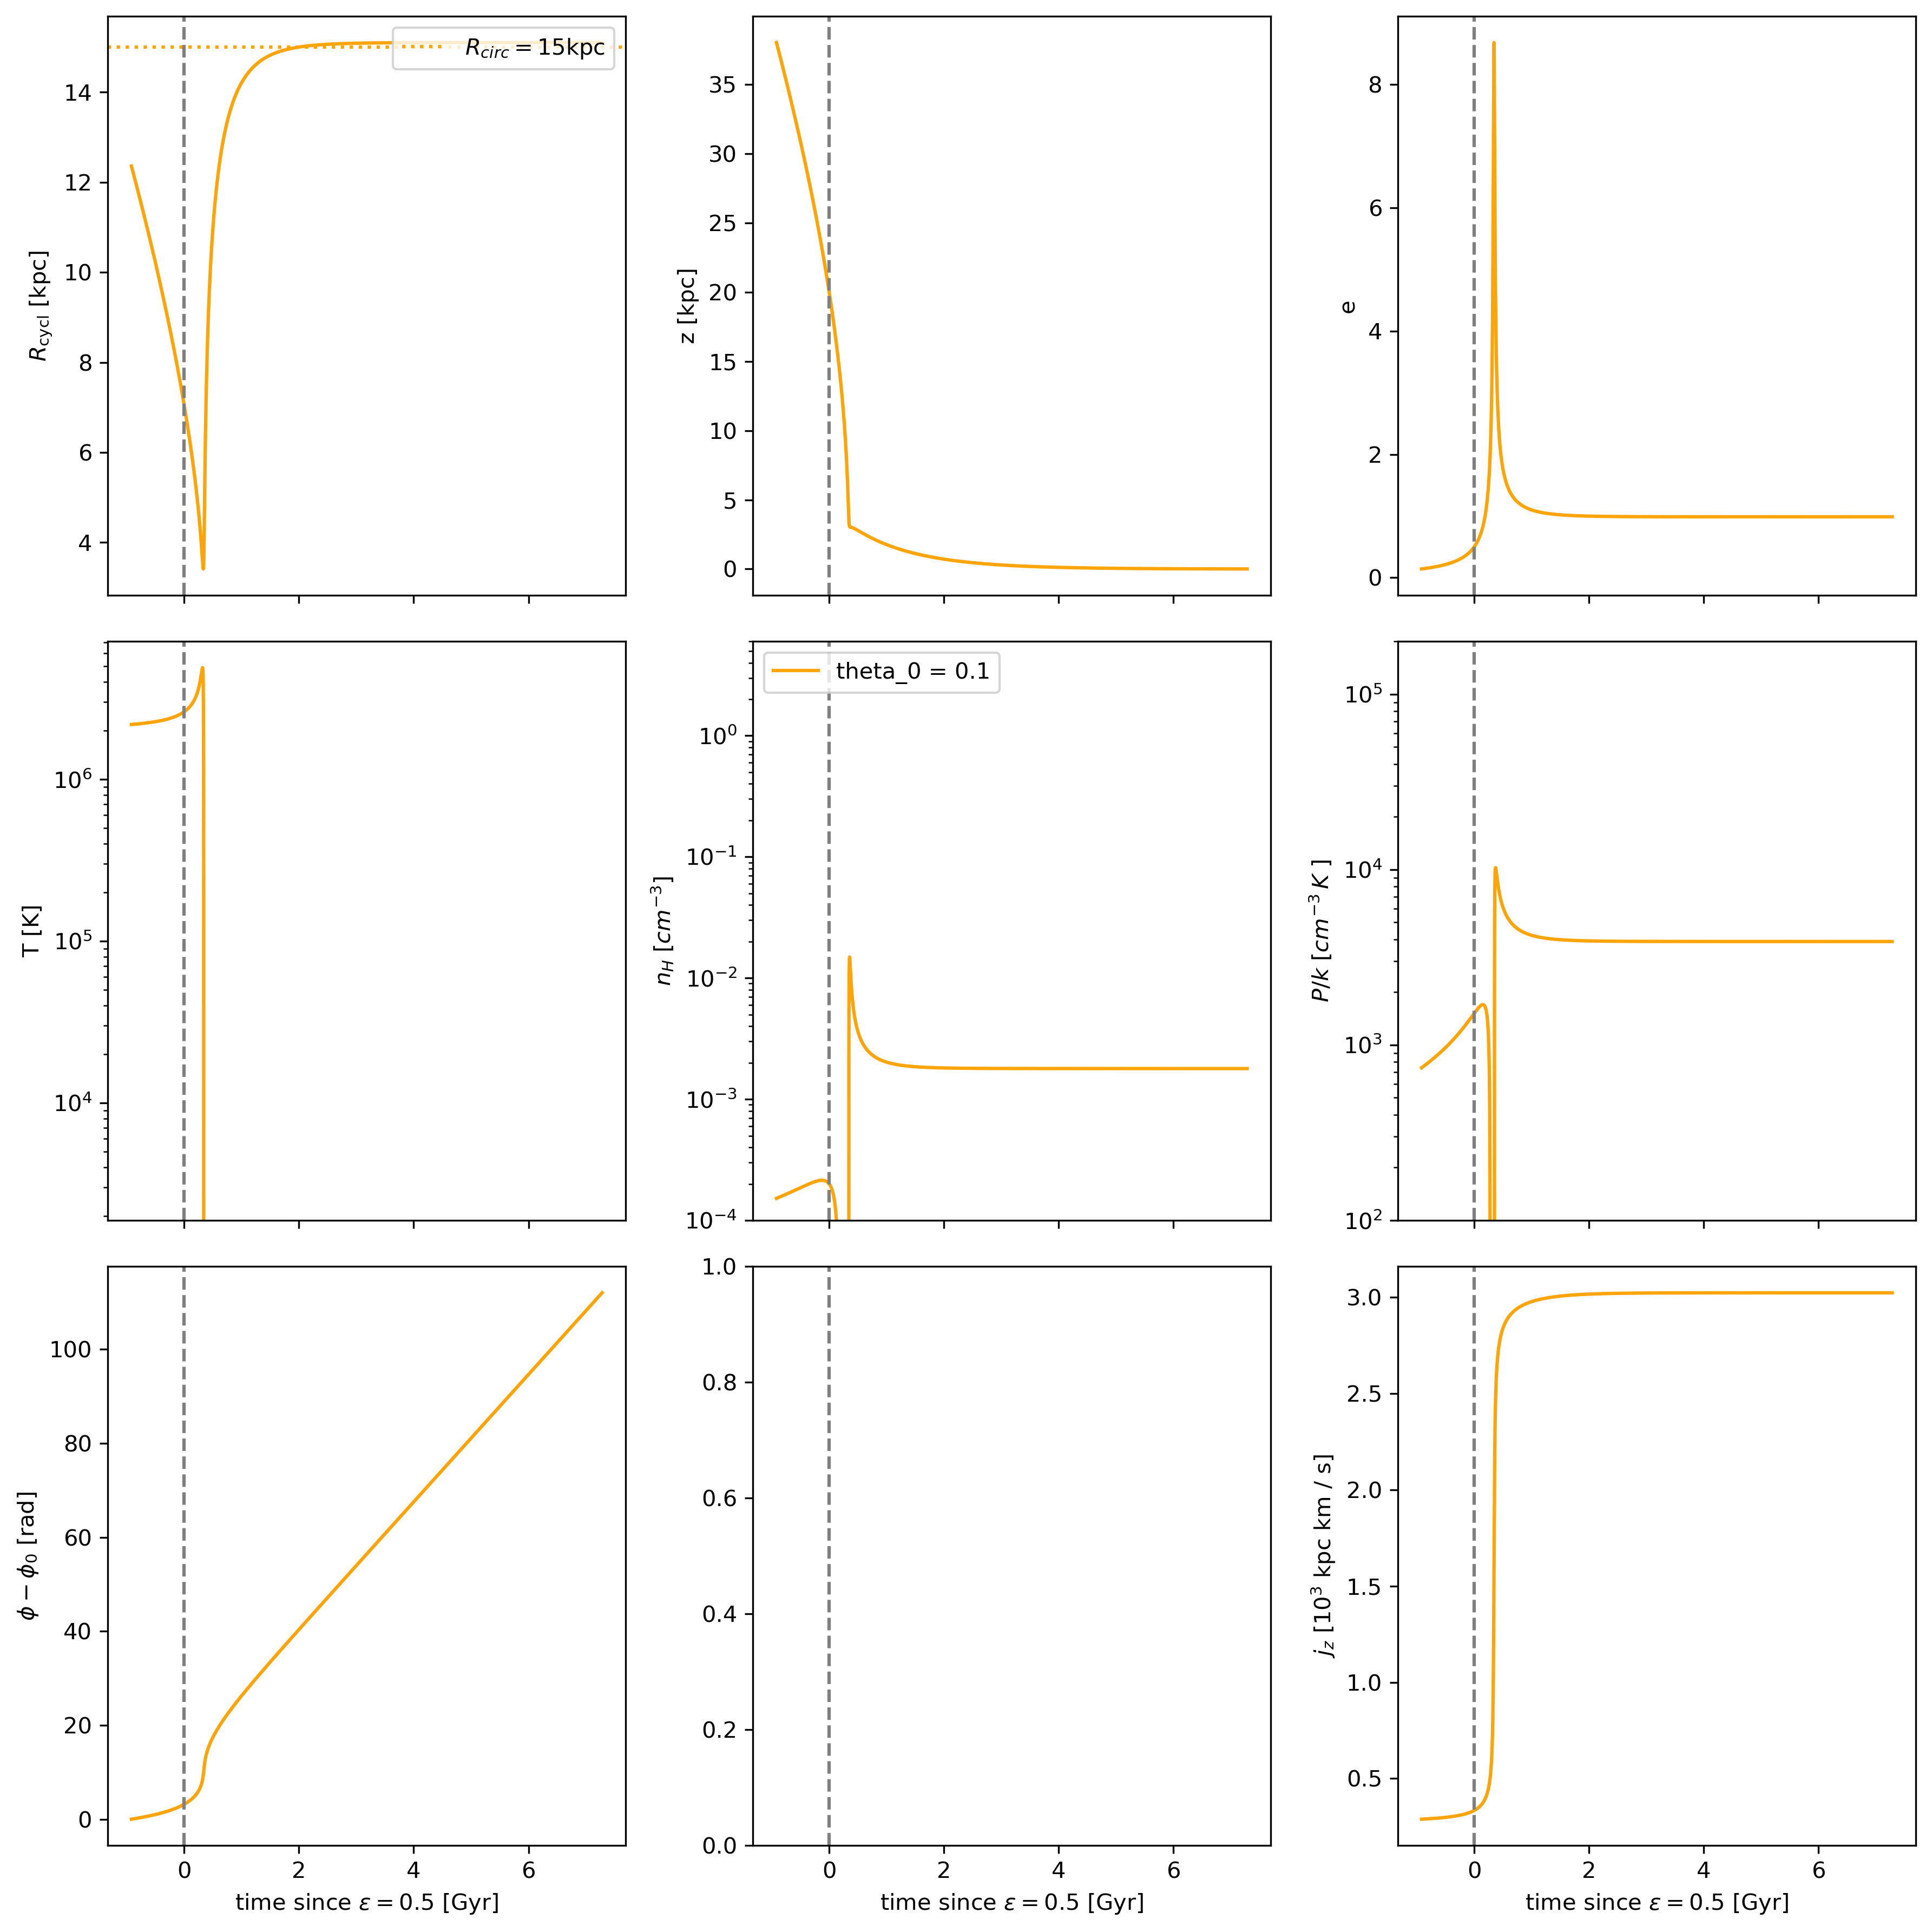

In [25]:
path,i = particle_path(40, 0.1*np.pi)
figax = plot_fig5_e(path, label='theta_0 = 0.1')

### Other

In [96]:
def plot_trajectory(path, figax=None, Rcirc=15, **kwargs):
    t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e = path.T
    
    if figax is None:
        figax = plt.subplots(1, 1)
    fig, ax = figax

    R = r*np.sin(theta)
    z = r*np.cos(theta)
    v_phi = R*Omega_r # kpc / Gyr
    v_phi *= 1 / (A_YEAR*1e9) / M_TO_PC # km / s
    
    jz = R*v_phi # kpc* (km / s)
    
    def find_temp(T, target):
        lower = np.arange(len(T))[T<target]
        if len(lower) == 0:
            return len(T)-1
        return lower[0]
    
    def find_e(e, target):
        lower = np.arange(len(e))[e<target]
        if len(lower) == 0:
            return len(e)-1
        return lower[-1]

    index_Tat5 = find_temp(T1, 1e5)
    index_e_at05 = find_e(e, 0.5)
    index_e_at1 = np.where(e > 1.0)[0]
    if len(index_e_at1) == 0:
        index_e_at1 = len(e) - 1
    else:
        index_e_at1 = index_e_at1[0]
        
    
    line, = ax.plot(R, z, **kwargs)
    ax.scatter(R[0], z[0], c=line.get_color(), marker='x')
    ax.scatter(R[index_e_at05], z[index_e_at05], c=line.get_color(), marker='^')
#     ax.scatter(R[index_Tat5], z[index_Tat5], c=line.get_color(), marker='o')

    ax.scatter(R[index_e_at1], z[index_e_at1], c=line.get_color(), marker='o')
    
    ax.set_ylabel('z [kpc]')
    ax.set_xlabel('R [kpc]')
    
#     ax.legend(loc='upper right')
    return figax

### Non rotating solutions

In [27]:
def plot_non_rot(path, figax=None, Rcirc=15, **kwargs):
    t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e = path.T
    
    if figax is None:
        figax = plt.subplots(5, 1, figsize=(7, 12), tight_layout=True)
    fig, ax = figax

    t_plot = t / (A_YEAR*1e9) # Gyr
    
    ax[0].plot(t_plot, r, **kwargs)
    ax[0].set_ylabel('r [kpc]')
    
    ax[1].plot(t_plot, T0, **kwargs)
    ax[1].set_ylabel('T [K]')
    ax[1].set_yscale('log')
    
    ax[2].plot(t_plot, P0, **kwargs)
    ax[2].set_ylabel(r'P/k [$cm^{-3} K$]')
    ax[2].set_yscale('log')
    
    ax[3].plot(t_plot, nH0, **kwargs)
    ax[3].set_ylabel(r'$n_H$ [$cm^{-3}$]')
    ax[3].set_yscale('log')
    
    ax[4].plot(t_plot, vr0, **kwargs)
    ax[4].set_ylabel(r'$v_r$ [km / s]')
    

    ax[-1].set_xlabel('t [Gyr]')
    
    return figax

## Reproducing paper conditions

In [28]:
r = 40
thetas = np.array([0.1, 0.3, 0.4, 0.5])*np.pi
# thetas = np.array([0.1, 0.2, 0.3, 0.4, 0.5])*np.pi

paths = []
for theta in thetas:
    p, i = particle_path(r, theta)
    print(f"Finished at iteration {i} ({i / 10000000 * 100:.2f} %)")
    paths.append(p)

dr < r_lim (limit reached), stopping early...
Finished at iteration 820178 (8.20 %)
dr < r_lim (limit reached), stopping early...
Finished at iteration 919144 (9.19 %)
dr < r_lim (limit reached), stopping early...
Finished at iteration 279996 (2.80 %)
dr < r_lim (limit reached), stopping early...
Finished at iteration 621177 (6.21 %)


Negative r, so we reached 0.
Finished at iteration 176319 (1.76 %)


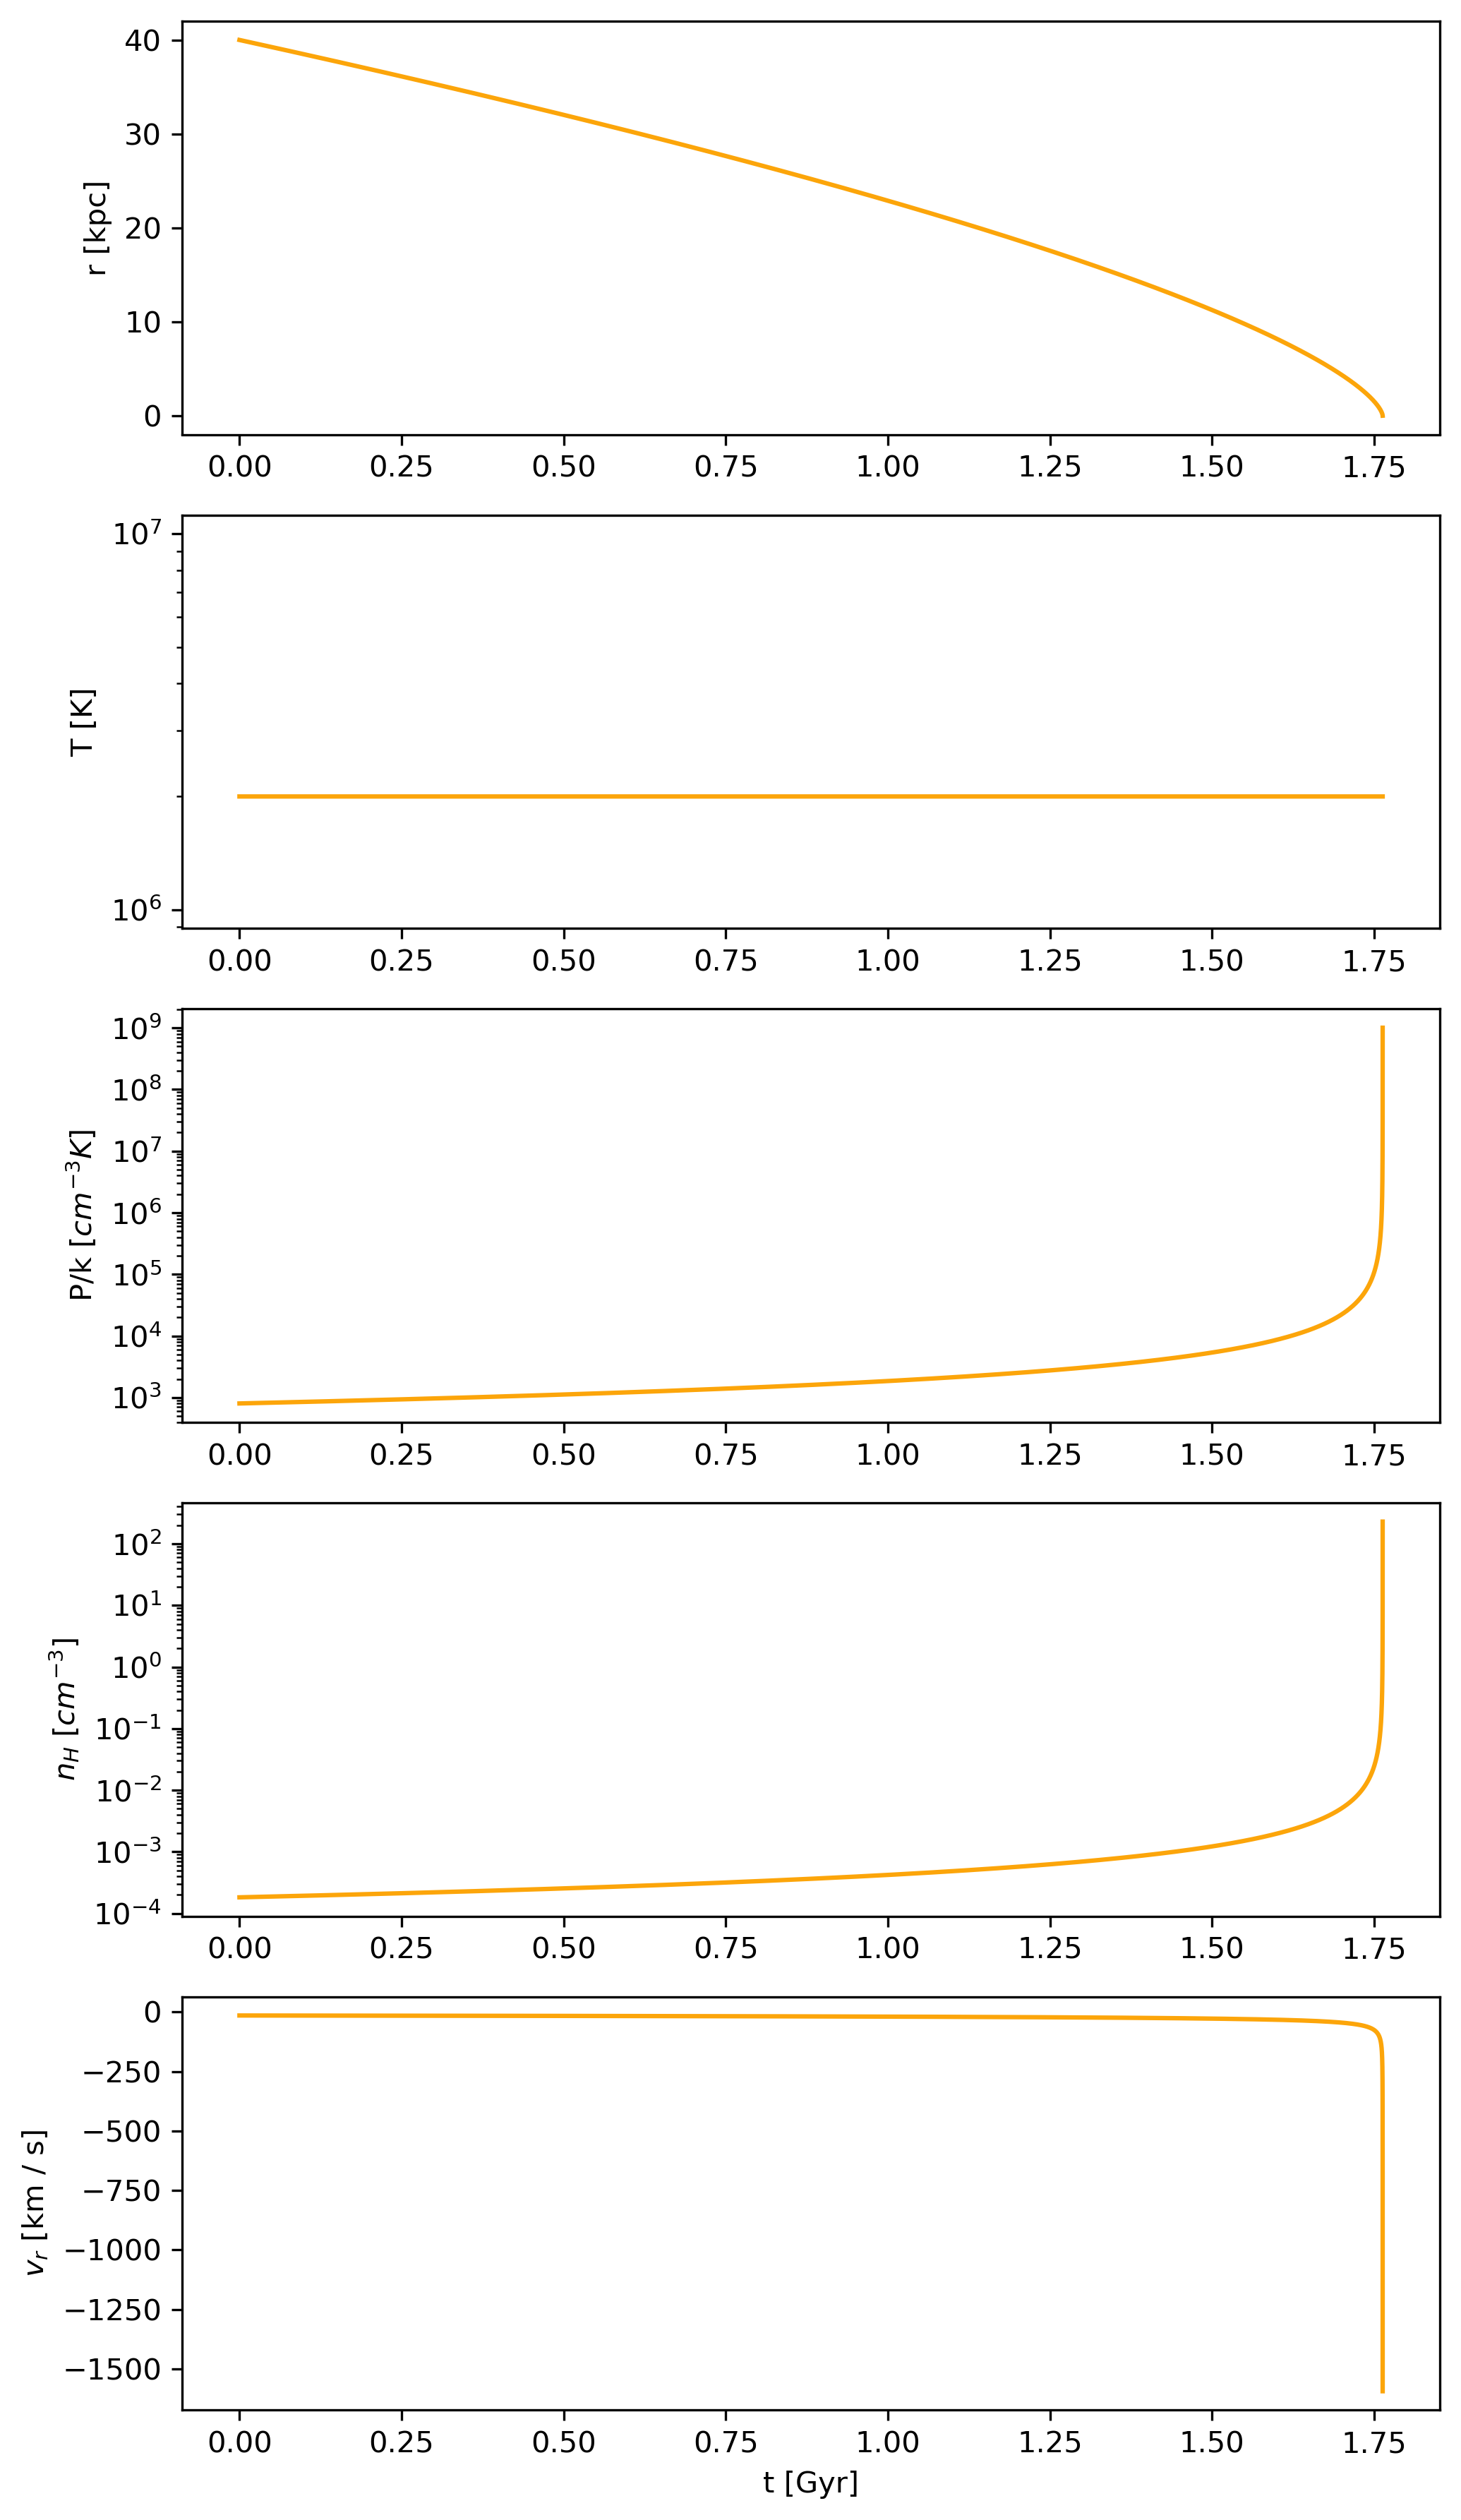

In [29]:
path_nr , i = particle_path_nr(r, theta)
print(f"Finished at iteration {i} ({i / 10000000 * 100:.2f} %)")

figax = plot_non_rot(path_nr)
fig, ax = figax
# ax[0].set_xlim(0, 2)

plt.show()    

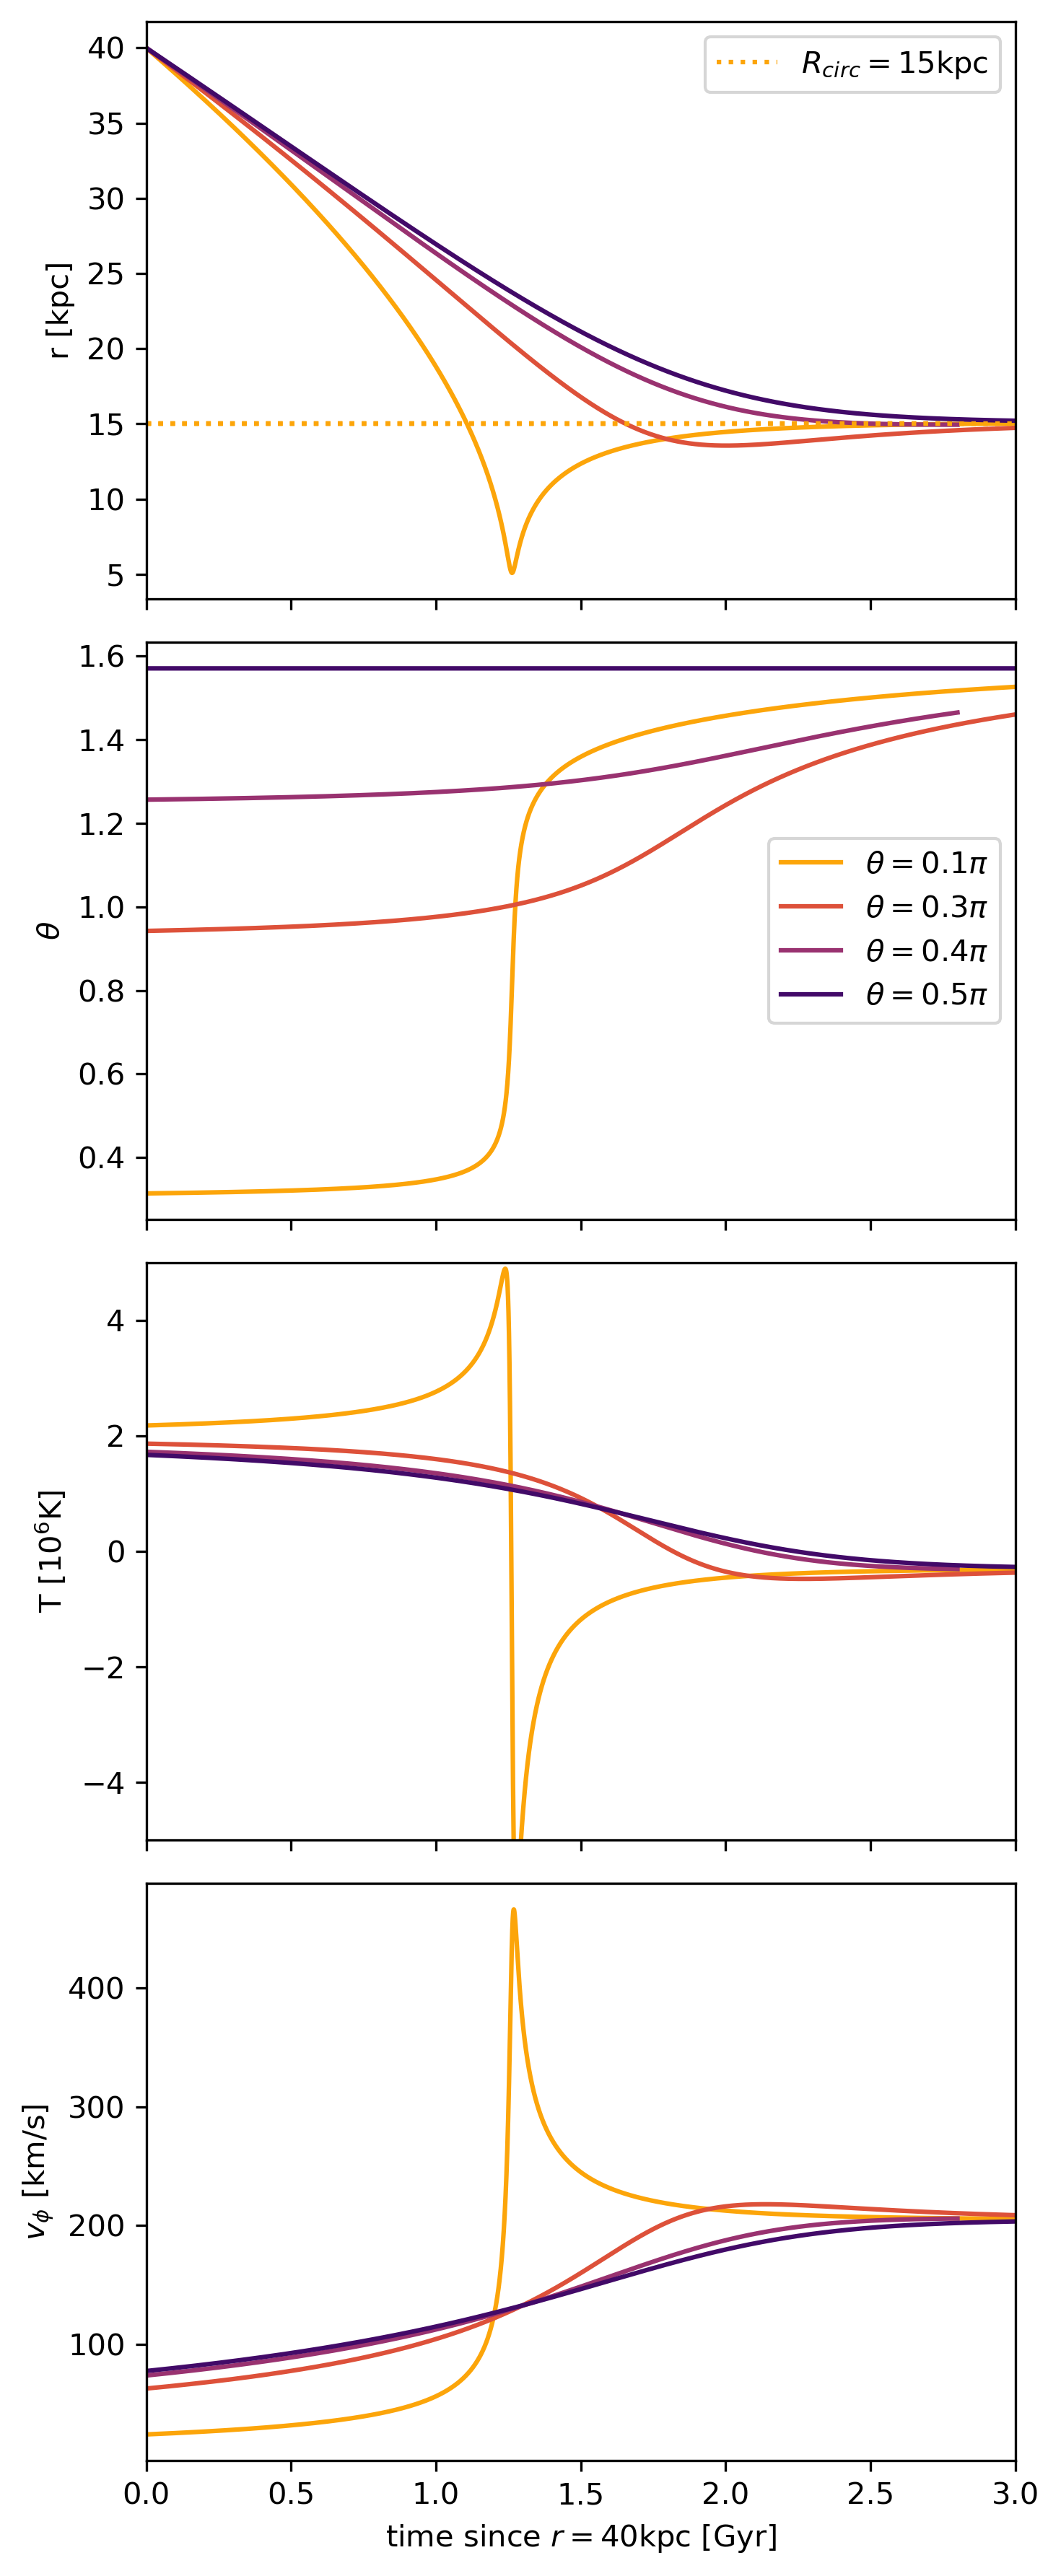

In [30]:
figax = None
for path, theta in zip(paths, thetas):
    figax = plot_fig3(path, figax=figax, label=r'$\theta = $' + f"{theta/np.pi}" + r'$\pi$')
    fig, ax = figax
    ax[0].set_xlim(0, 3)
    ax[2].set_ylim(-5, 5)
    
plt.savefig(save_name("figure-3"))
plt.show()    

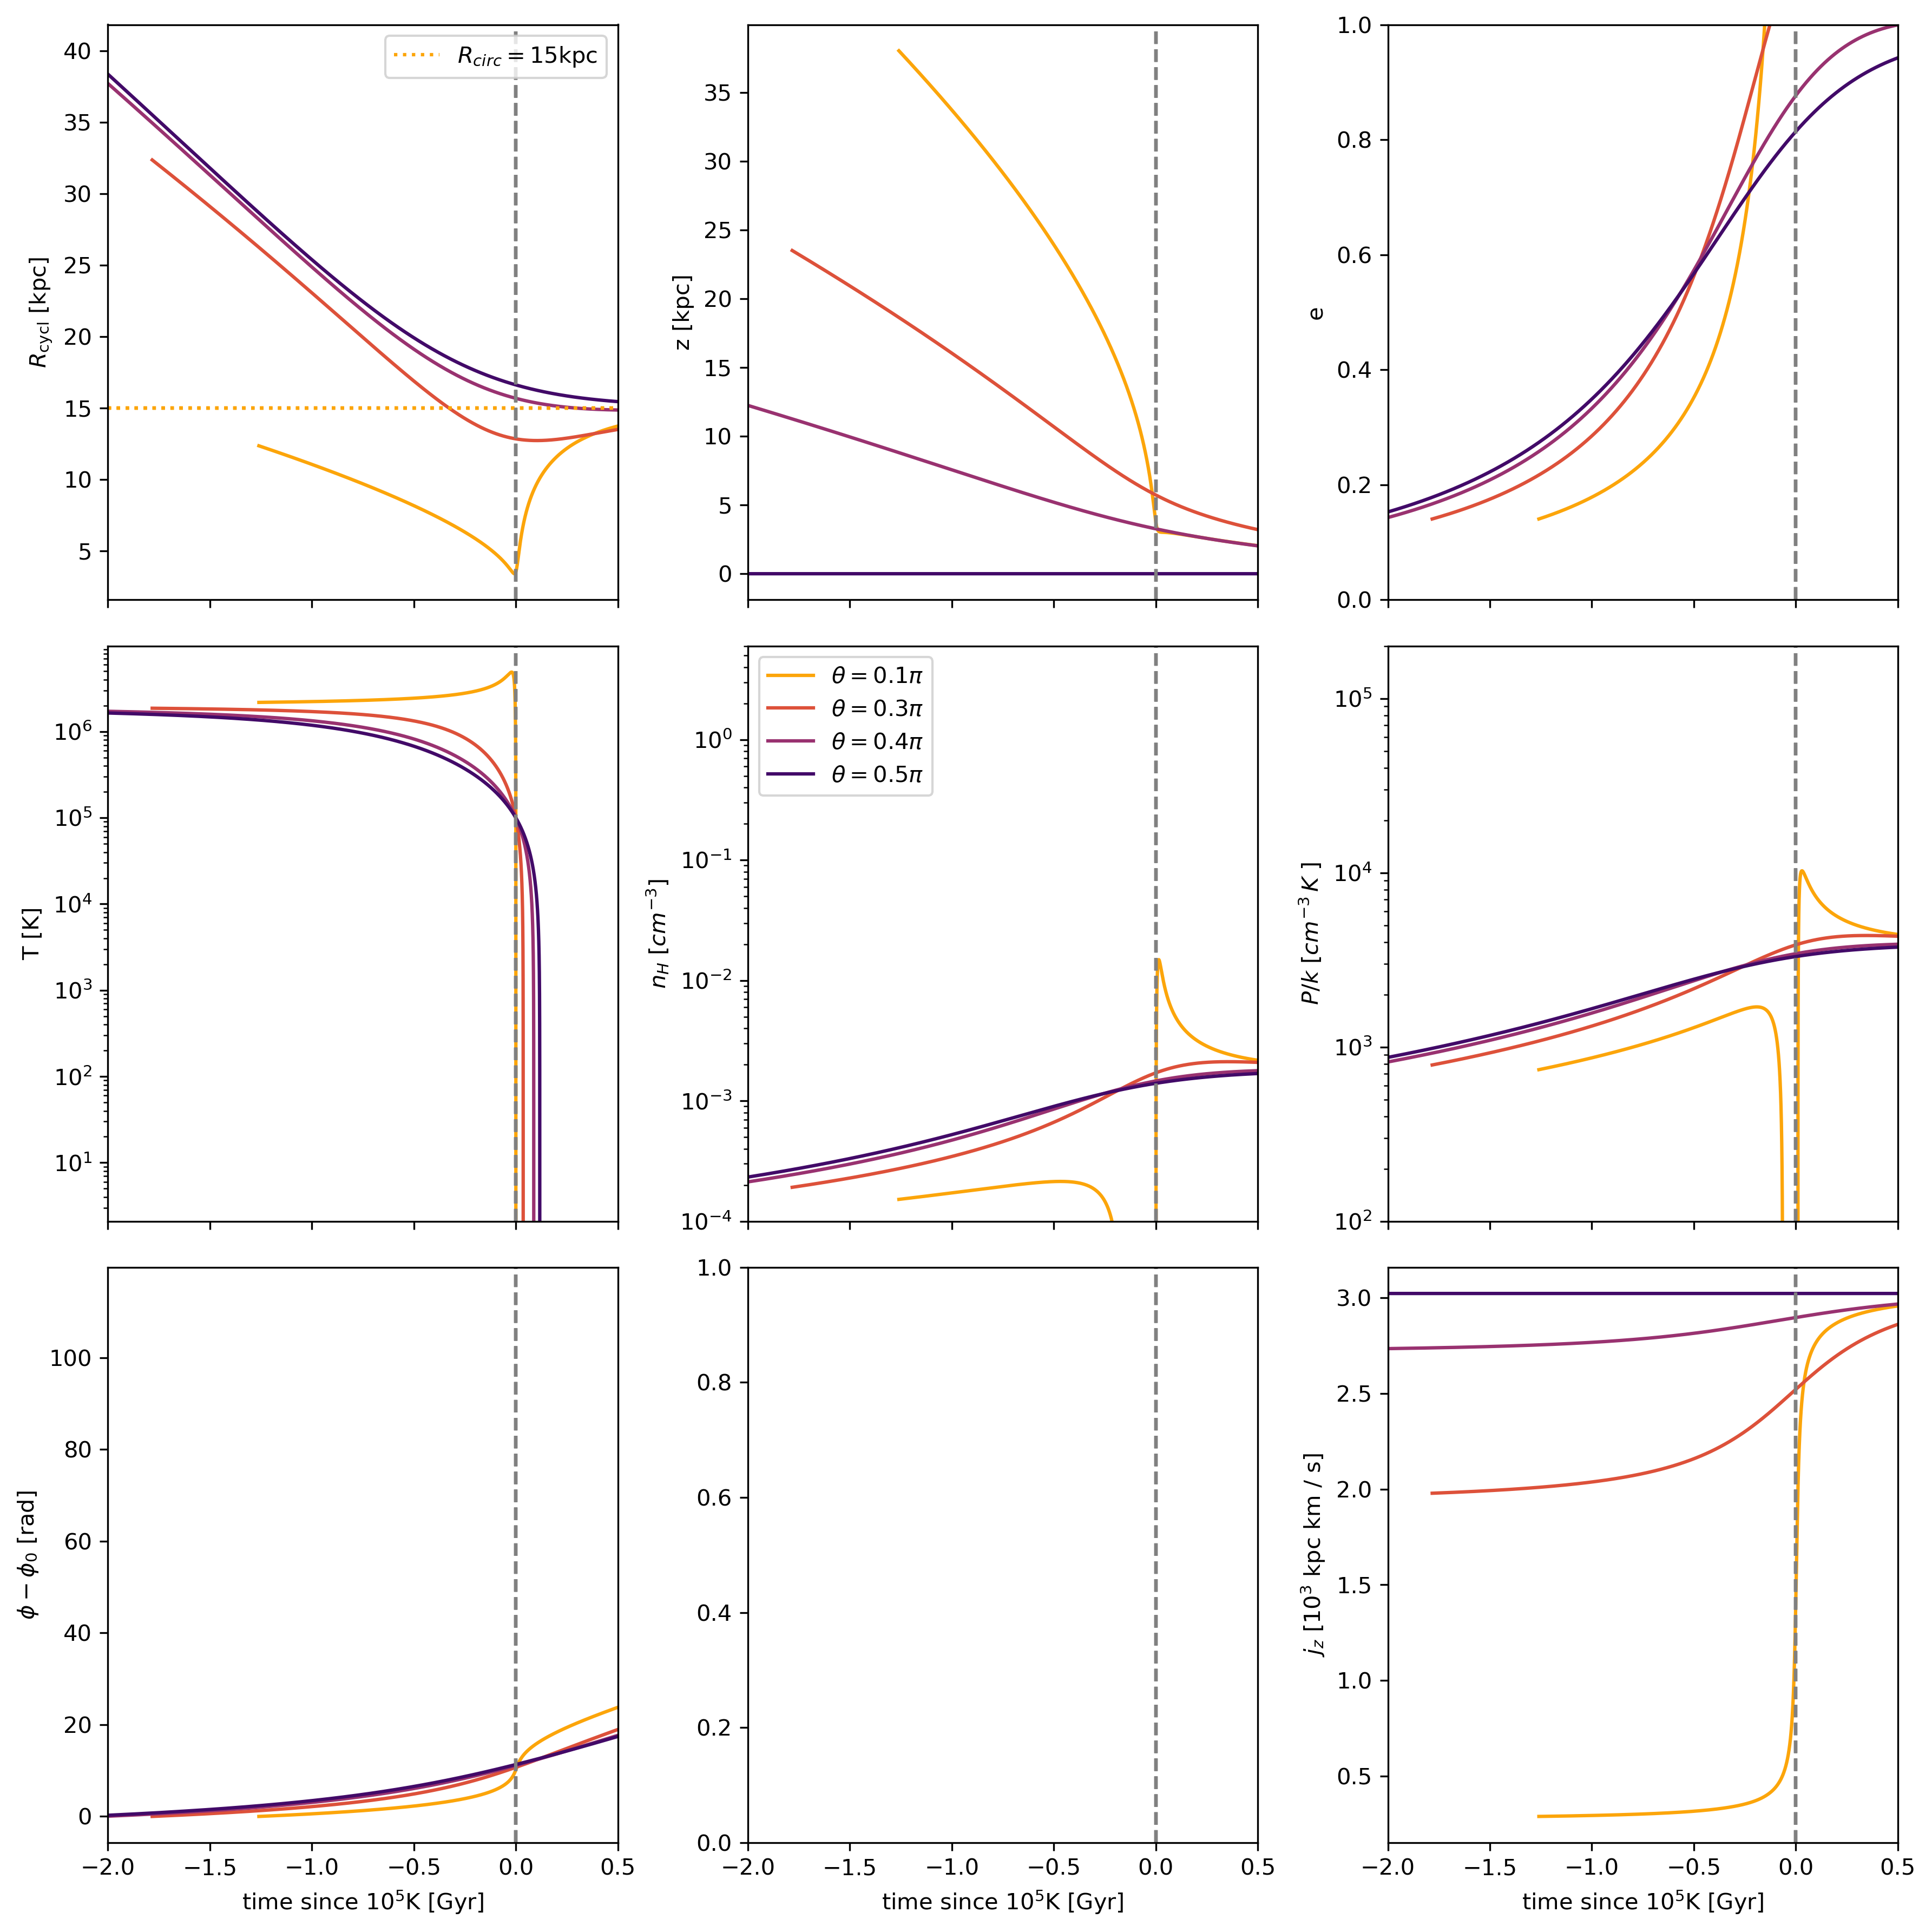

In [31]:
figax = None
for path, theta in zip(paths, thetas):
    figax = plot_fig5(path, figax=figax, label=r'$\theta = $' + f"{theta/np.pi}" + r'$\pi$')
    fig, axs = figax
    axs[0, 2].set_ylim(0, 1)
    for ax in axs[2, :]:
        ax.set_xlim(-2, 0.5)

plt.savefig(save_name("figure-5-temp"))
plt.show()    

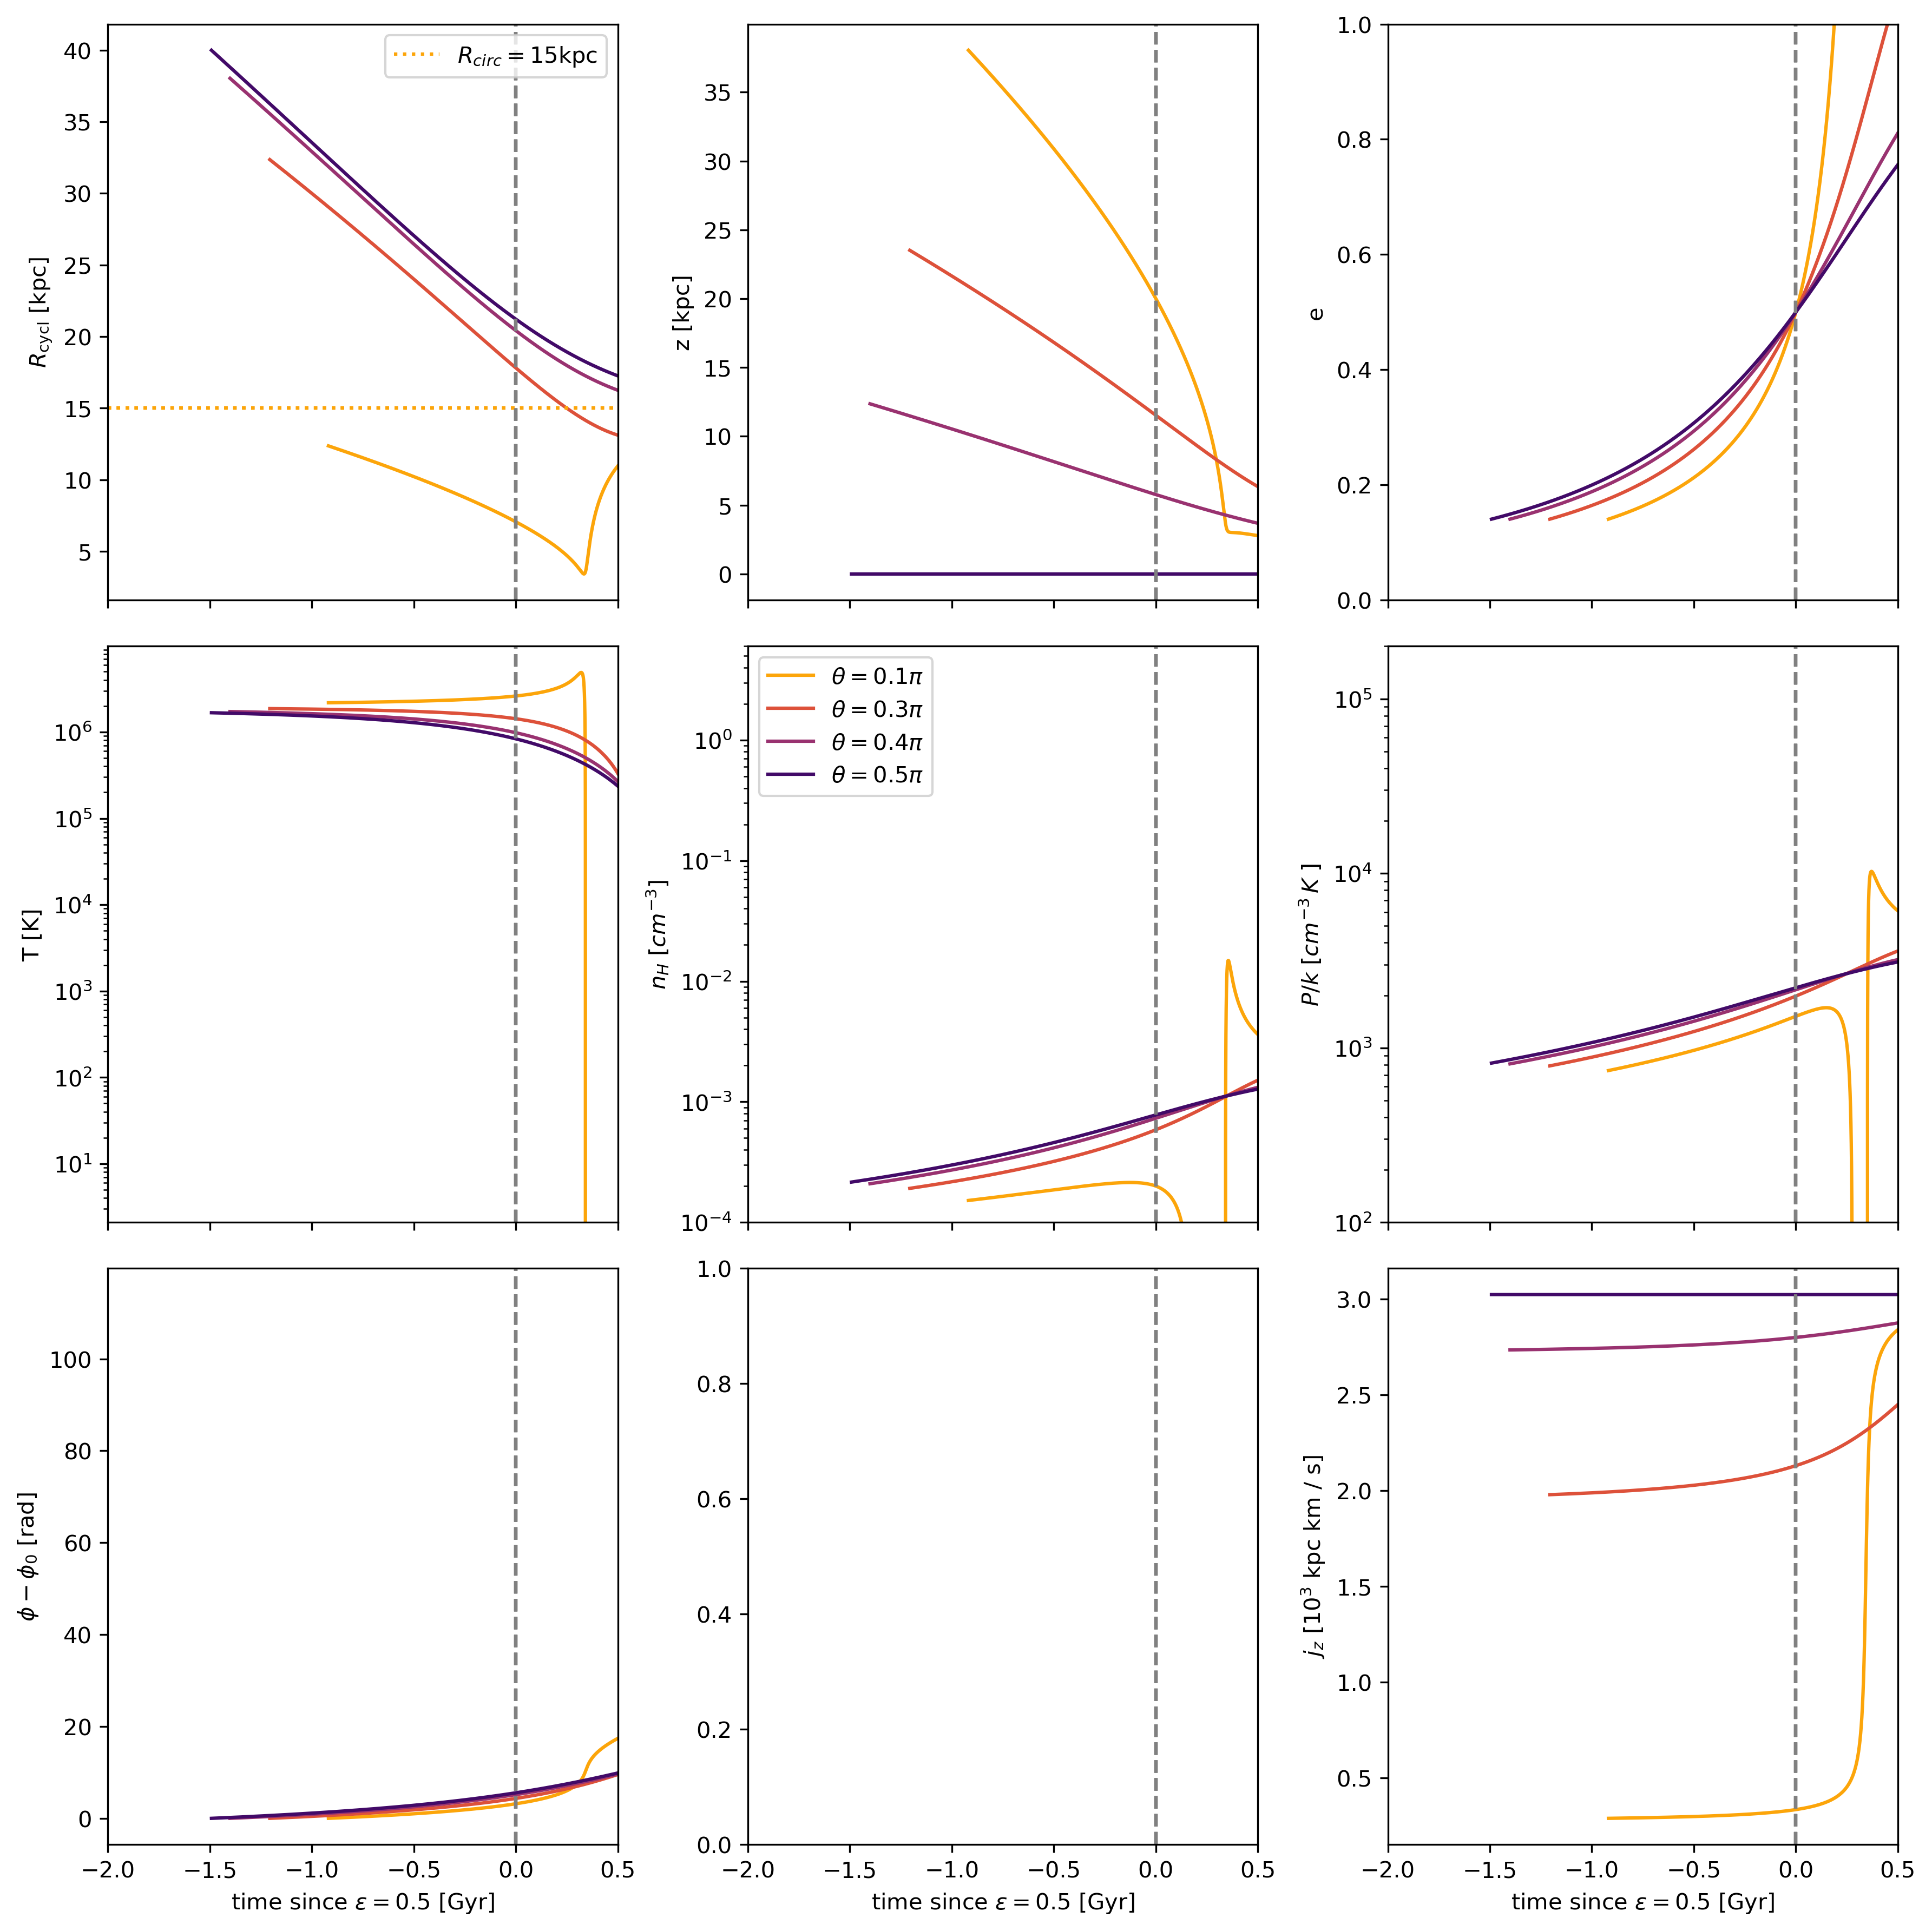

In [32]:
figax = None
for path, theta in zip(paths, thetas):
    figax = plot_fig5_e(path, figax=figax, label=r'$\theta = $' + f"{theta/np.pi}" + r'$\pi$')
    fig, axs = figax
    axs[0, 2].set_ylim(0, 1)
    for ax in axs[2, :]:
        ax.set_xlim(-2, 0.5)

plt.savefig(save_name("figure-5-epsilon"))
plt.show()    

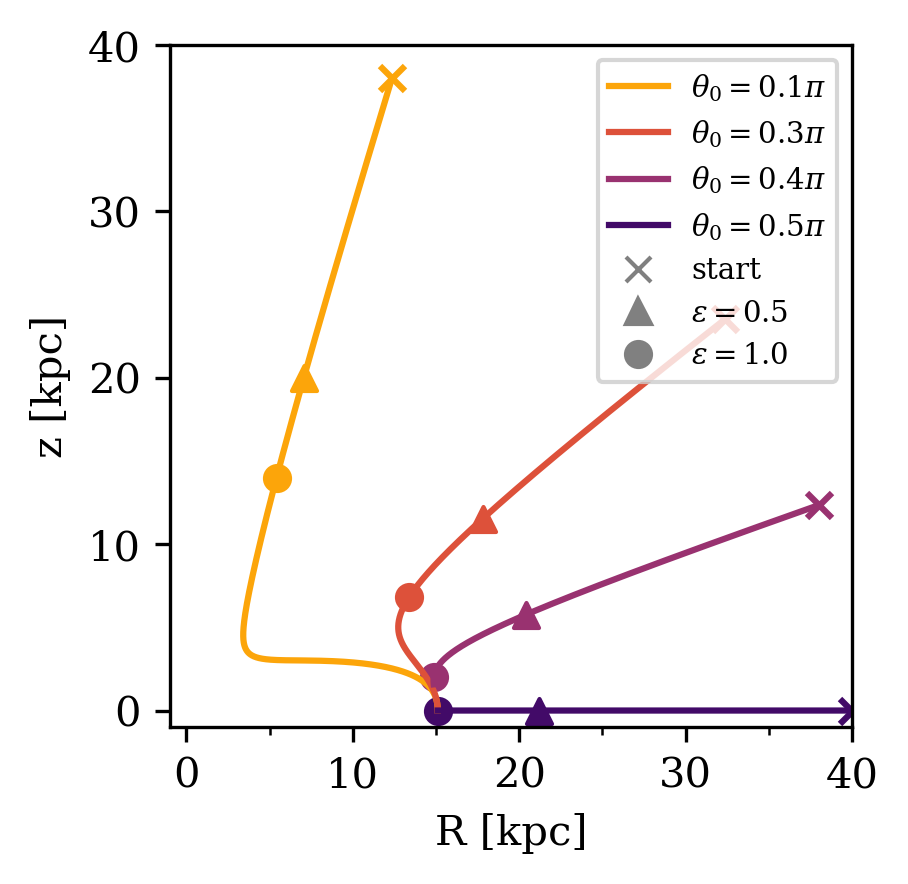

In [107]:
from matplotlib.lines import Line2D

figax = plt.subplots(1, 1, figsize=(MPL_STD_WIDTH/1.5, MPL_STD_HEIGHT/1.5))
# figax = plt.subplots(1, 1, figsize=(MPL_STD_WIDTH/2, MPL_STD_HEIGHT/2))
theta_labels = []
for path, theta in zip(paths, thetas):
    figax = plot_trajectory(path, label = r'$\theta_0 = $' + f"{theta/np.pi}"+ r'$\pi$', figax=figax)
    
    t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e = path.T
    R = r*np.sin(theta)
    z = r*np.cos(theta)
    
    fig, ax = figax
#     ax.plot([0, R[0]], [0, z[0]], alpha=0.5, c='gray', ls='--')
    
# For creating the legend:
start = Line2D([0], [0], color='gray', marker='x', lw=0, label='start')
e_loc = Line2D([0], [0], color='gray', marker='^', lw=0, label=r'$\epsilon = 0.5$')
T_loc = Line2D([0], [0], color='gray', marker='o', lw=0, label=r'$\epsilon = 1.0$')

fig, ax = figax
lines = ax.get_lines()
ax.legend(handles=lines + [start, e_loc, T_loc], loc='upper right', fontsize=7)

ax.set_ylim(-1, 40)
ax.set_xlim(-1, 40)
ax.set_aspect(1)
ax.set_xticks(np.arange(0, 41, 10))
ax.set_xticks(np.arange(0, 41, 5), minor=True)

savefig(fig, "paths-z-R")
plt.show()    

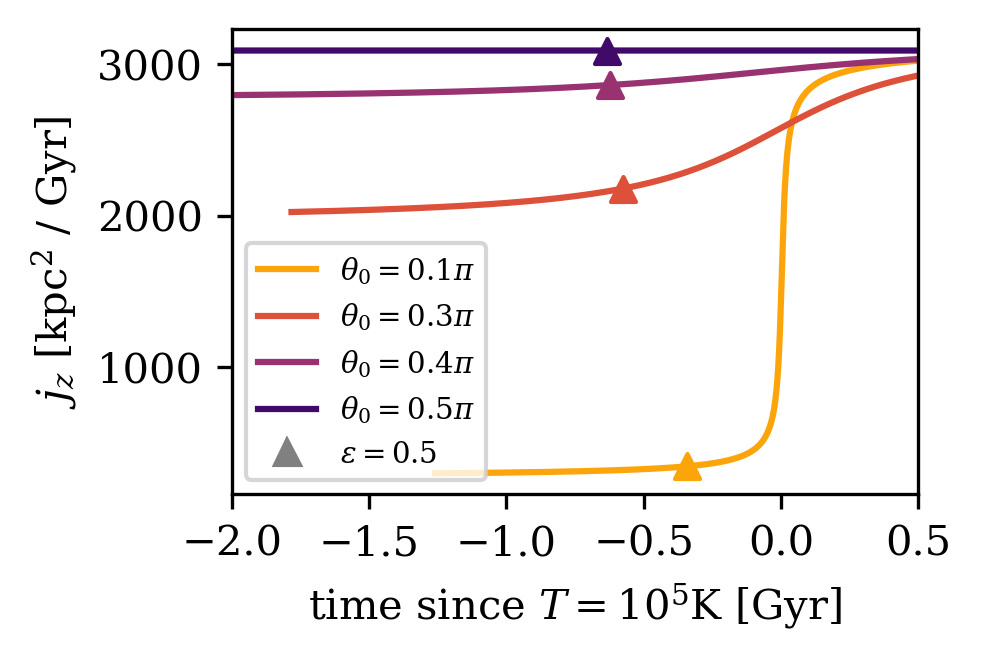

In [109]:
from matplotlib.lines import Line2D

figax = plt.subplots(1, 1, figsize=(MPL_STD_WIDTH/2, MPL_STD_HEIGHT/2.2))
theta_labels = []
for path, theta0 in zip(paths, thetas):
#     figax = plot_trajectory(path, label = r'$\theta_0 = $' + f"{theta/np.pi}"+ r'$\pi$', figax=figax)
    
    t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e = path.T
    R = r*np.sin(theta)
    z = r*np.cos(theta)
    
    def find_temp(T, target):
        lower = np.arange(len(T))[T>target]
        if len(lower) == 0:
            return len(T)-1
        return lower[-1]
    t_Tat5 = t[find_temp(T1, 1e5)]
    
    def find_e(e, target):
        lower = np.arange(len(e))[e<target]
        if len(lower) == 0:
            return len(e)-1
        return lower[-1]

    index_e_at05 = find_e(e, 0.5)
    
    jz = R**2*Omega_r
    t_plot = (t - t_Tat5) / (A_YEAR*1e9)
    
    fig, ax = figax
    line, = ax.plot(t_plot, jz, label=r'$\theta_0 = $' + f"{theta0/np.pi}"+ r'$\pi$',)
    ax.scatter(t_plot[index_e_at05], jz[index_e_at05], c=line.get_color(), marker='^')
    
#     ax.plot([0, R[0]], [0, z[0]], alpha=0.5, c='gray', ls='--')
ax.set_xlim(-2, 0.5)    
# For creating the legend:
e_loc = Line2D([0], [0], color='gray', marker='^', lw=0, label=r'$\epsilon = 0.5$')

fig, ax = figax
lines = ax.get_lines()
ax.legend(handles=lines + [e_loc], loc='lower left', fontsize=7)

ax.set_ylabel('$j_z$ [kpc$^2$ / Gyr]')
ax.set_xlabel(r'time since $T=10^5$K [Gyr]')


savefig(fig, "ang-momentum-conserv")
plt.show()    

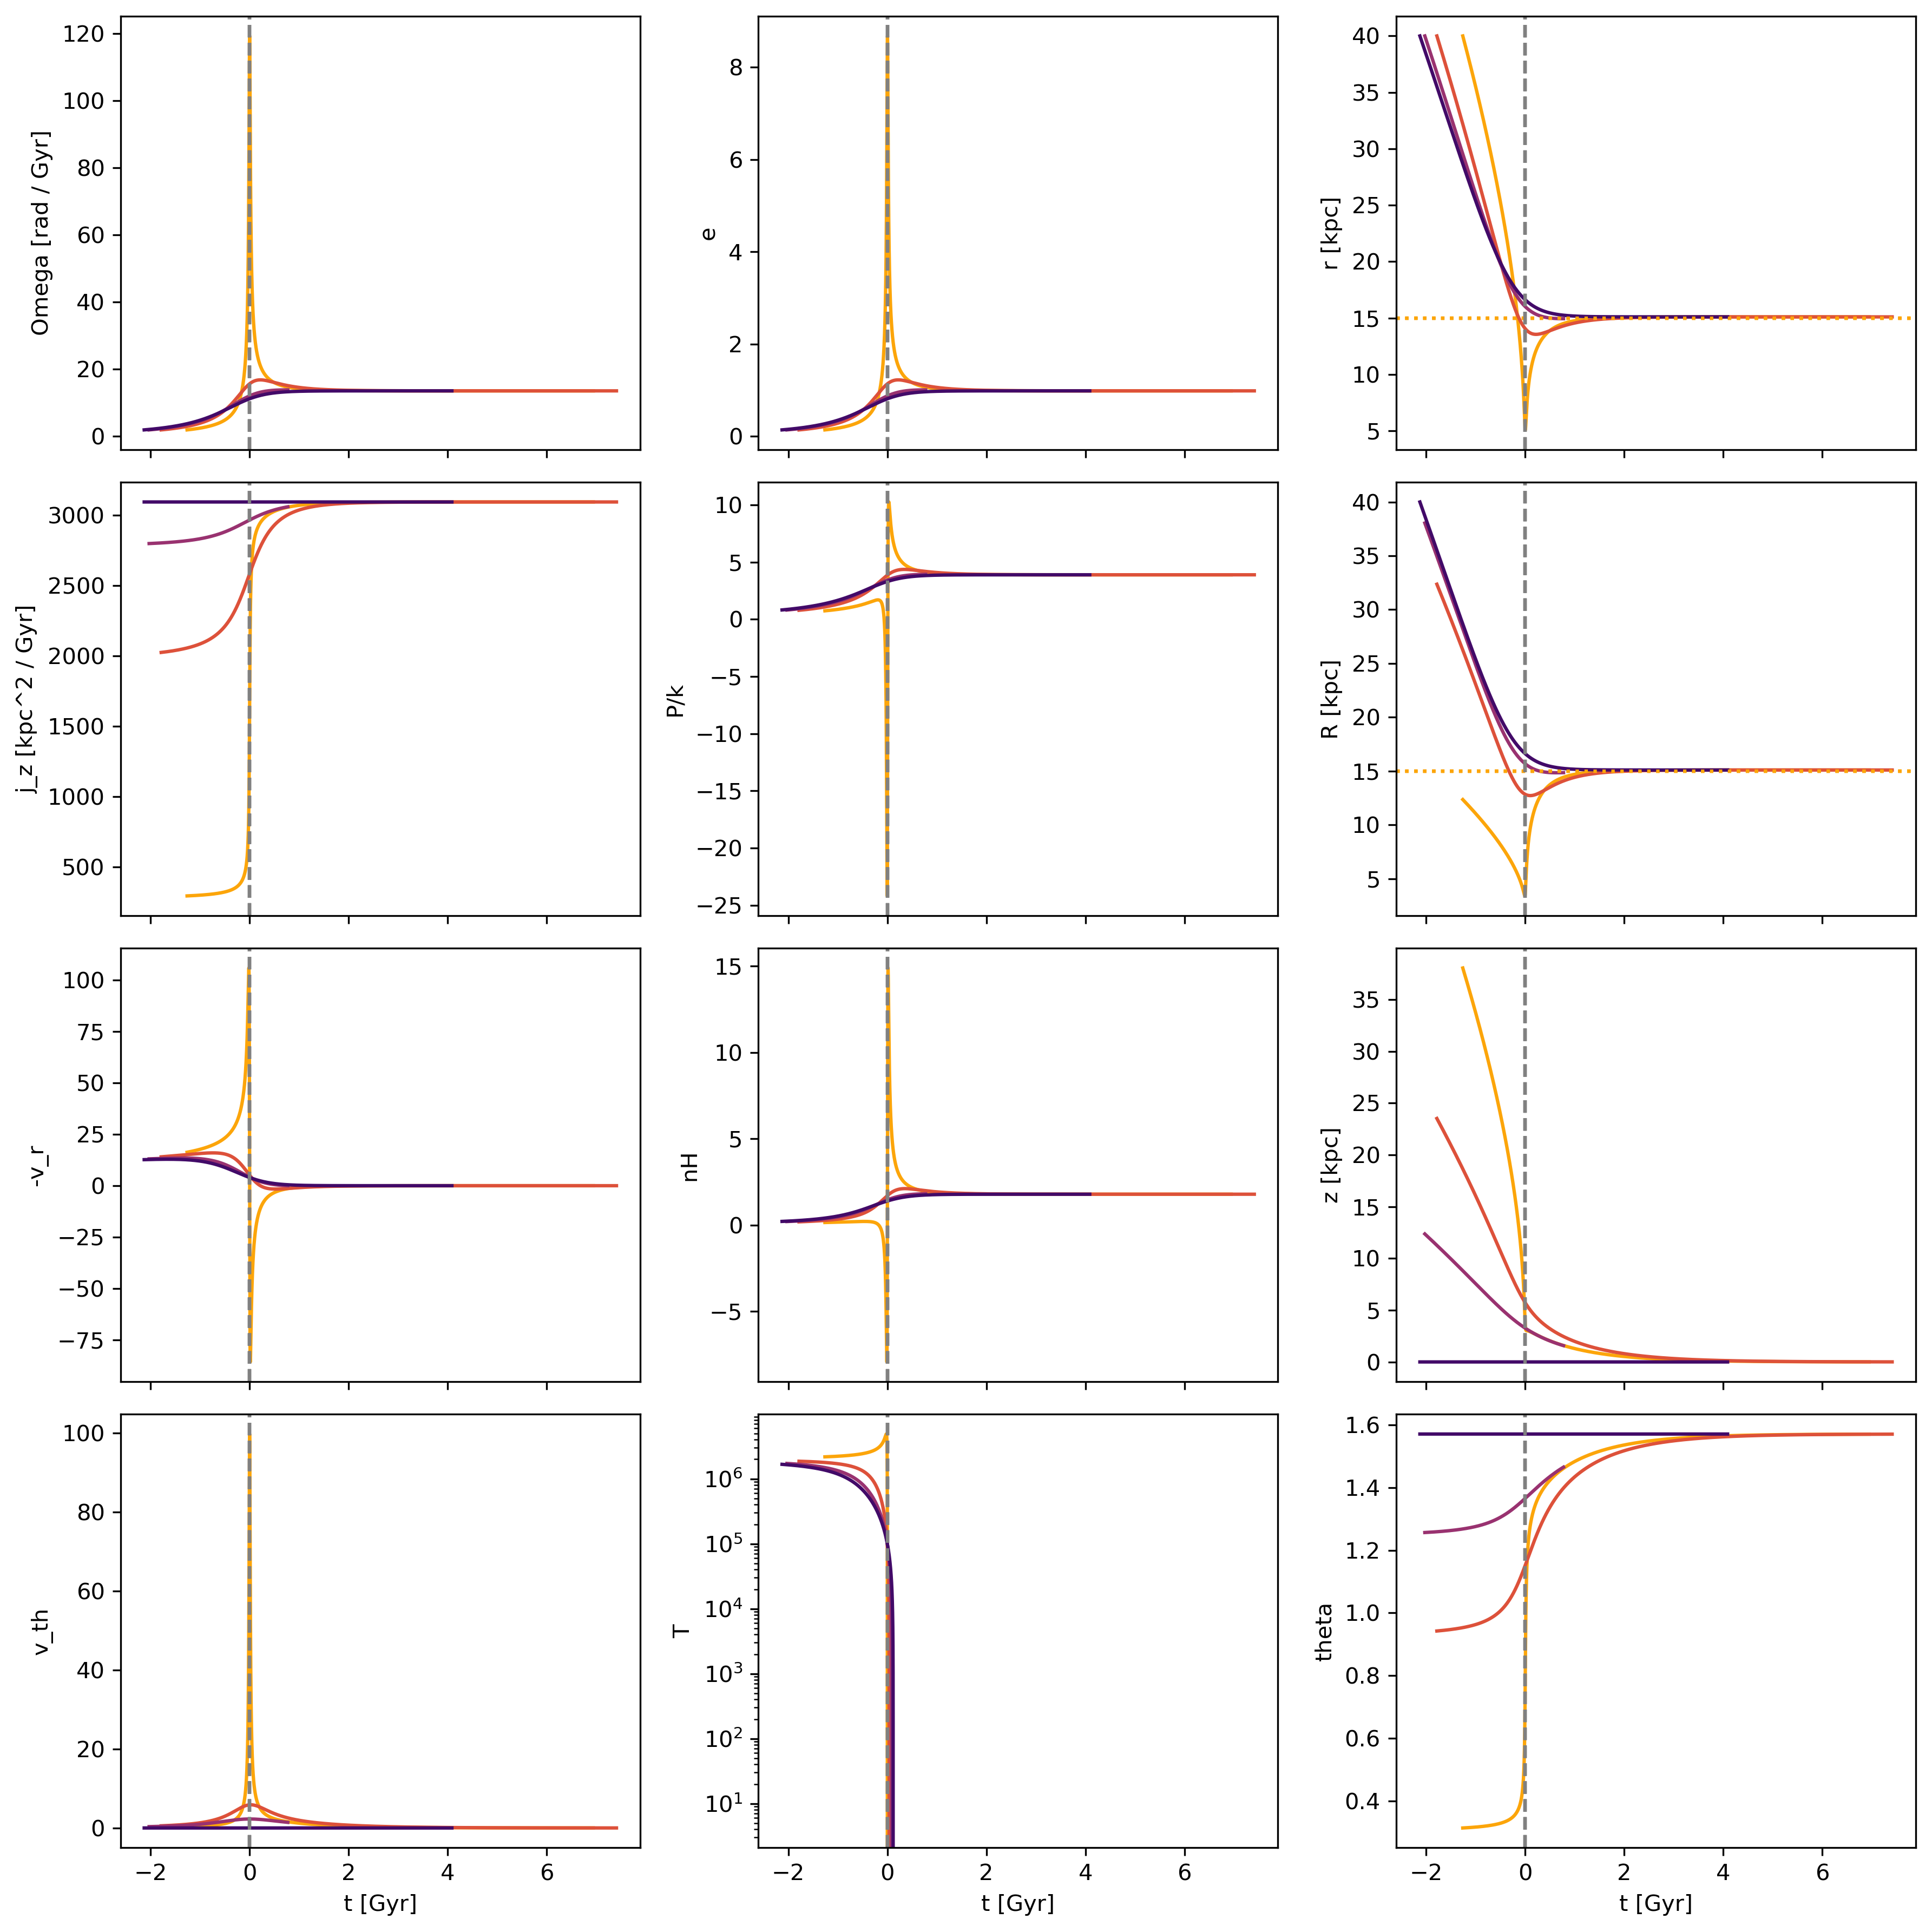

In [34]:
figax = None
for path, theta in zip(paths, thetas):
    figax = plot_path(path, figax=figax)
    
plt.show()    

## Other: T in R-z


In [35]:
def plot_trajectory_face(path, figax=None, Rcirc=15, **kwargs):
    t, r, theta, T0, nH0, P0, vr0, Omega_r, P1, T1, nH1, vr1, vth, e = path.T
    
    if figax is None:
        figax = plt.subplots(1, 1, figsize=(7, 7), tight_layout=True)
    fig, ax = figax
    ax.set_aspect(1)
    phi = compute_phi(path)
    
    R = r*np.sin(theta)
    z = r*np.cos(theta)
    
    x = R*np.cos(phi)
    y = R*np.sin(phi)
    
    def find_temp(T, target):
        lower = np.arange(len(T))[T<target]
        if len(lower) == 0:
            return len(T)-1
        return lower[0]
    
    def find_e(e, target):
        lower = np.arange(len(e))[e<target]
        if len(lower) == 0:
            return len(e)-1
        return lower[-1]

    index_Tat5 = find_temp(T1, 1e5)
    index_e_at05 = find_e(e, 0.5)
    
    line, = ax.plot(x, y, **kwargs)
    
    ax.scatter(x[0], y[0], c=line.get_color(), marker='x')
    ax.scatter(x[index_e_at05], y[index_e_at05], c=line.get_color(), marker='^')
    ax.scatter(x[index_Tat5], y[index_Tat5], c=line.get_color(), marker='o')
    
    ax.set_ylabel('y [kpc]')
    ax.set_xlabel('x [kpc]')
    
    return figax

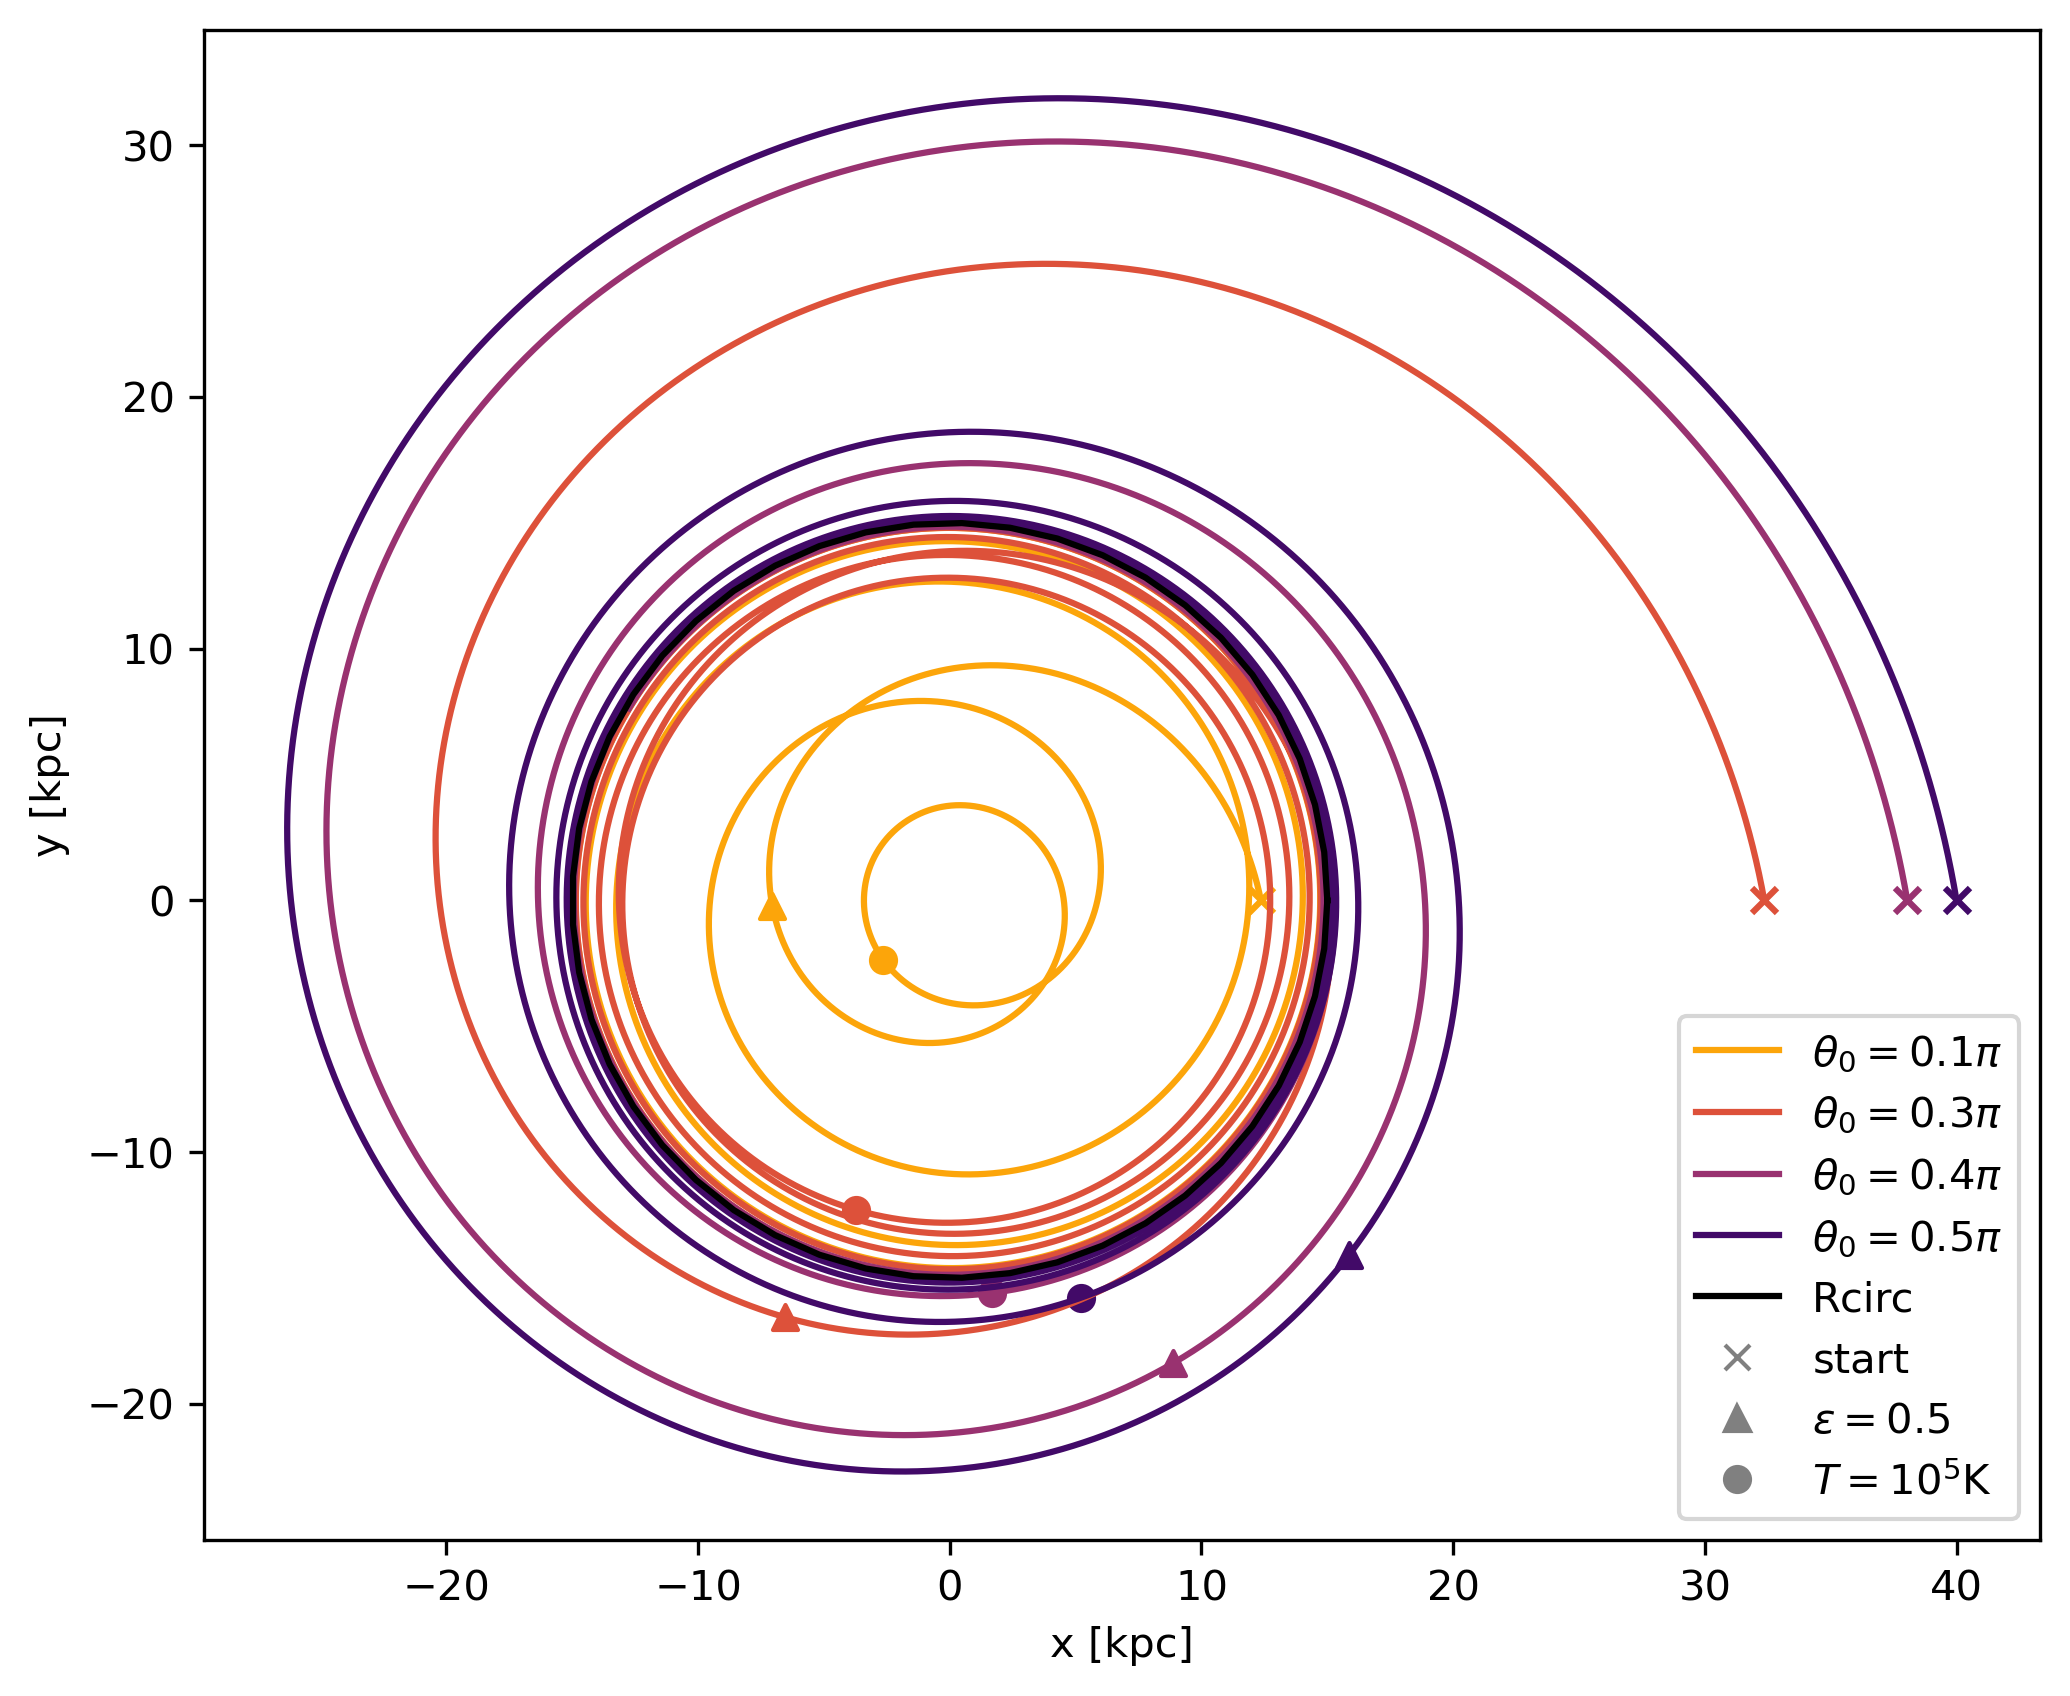

In [36]:
from matplotlib.lines import Line2D

figax = None
theta_labels = []
for path, theta in zip(paths, thetas):
    figax = plot_trajectory_face(path, label = r'$\theta_0 = $' + f"{theta/np.pi}"+ r'$\pi$', figax=figax)
    
fig, ax = figax

ref_phi = np.linspace(0, 2*np.pi)
ref_R = 15
ax.plot(ref_R*np.cos(ref_phi), ref_R*np.sin(ref_phi), c='k', label='Rcirc')


# For creating the legend:
start = Line2D([0], [0], color='gray', marker='x', lw=0, label='start')
e_loc = Line2D([0], [0], color='gray', marker='^', lw=0, label=r'$\epsilon = 0.5$')
T_loc = Line2D([0], [0], color='gray', marker='o', lw=0, label=r'$T = 10^5$K')

lines = ax.get_lines()
ax.legend(handles=lines + [start, e_loc, T_loc], loc='lower right')

plt.savefig(save_name("paths-circular"))
plt.show()    

## Fields


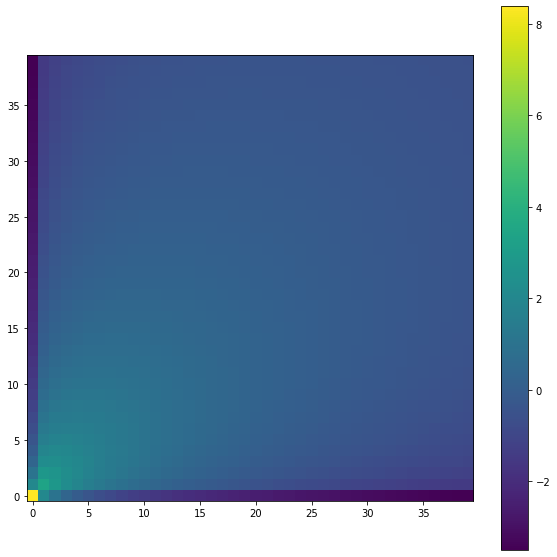

In [52]:
z = np.arange(0.01, 40)
R = np.arange(0.01, 40)

r = np.sqrt(z**2 + R**2)
theta = np.arctan2(R, z)


zs, Rs = np.meshgrid(z, R)

rs = np.sqrt(zs**2 + Rs**2)
thetas = np.arctan2(Rs, zs)

(T0, nH0, P0, vr0), (Omega_r, P1, T1, nH1, vr1, vth), e = quantities(rs, thetas)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
# im = ax.imshow(np.log10(-vr1), origin='lower')
im = ax.imshow(np.log10(vth), origin='lower')
fig.colorbar(im, ax=ax)

In [47]:
vr1[-10:]

array([[-12.74869238, -12.75921234, -12.79003451, -12.84020992,
        -12.90821567, -12.9920315 , -13.08923799, -13.19712875,
        -13.31282853, -13.43340946, -13.55599844, -13.67787047,
        -13.79652436, -13.90973894, -14.01560977, -14.11256751,
        -14.19938016, -14.27514191, -14.33925177, -14.39138485,
        -14.43145915, -14.45960026, -14.47610583, -14.4814115 ,
        -14.4760591 , -14.46066807, -14.43591027, -14.40248839,
        -14.3611179 , -14.31251228, -14.25737129, -14.19637191,
        -14.13016166, -14.05935381, -13.9845244 , -13.90621049,
        -13.82490955, -13.74107972, -13.65514068, -13.56747507],
       [-12.81141849, -12.82021481, -12.84599807, -12.88800659,
        -12.94501544, -13.0153946 , -13.09718386, -13.18817907,
        -13.28602379, -13.38830059, -13.4926167 , -13.59667995,
        -13.69836194, -13.79574678, -13.88716507, -13.97121341,
        -14.04676114, -14.11294586, -14.16916024, -14.21503208,
        -14.25039996, -14.27528628, -14